<h2>About this project</h2>

This is an educational project workthrough as presented in chapter 2 of Aurelien Gérons' book *Hands On Machine Learning with Scikit-Learn, Keras and Tensor Flow*. 

I applied my very own feature engineering ideas and thus successfully improved the performance of the Random Forest Regressor used in the book.

It is based on the often-used *California Housing Prices* dataset, which contains California census data from 1990. The scenario from the book is that a company is unhappy with manually estimating housing prices - in order to avoid this effort in the future, they hire a team that is supposed to solve this problem via Machine Learning, and "we" are part of that team.

**Instead of just reading or copying I typed it down myself and added plenty of code, comments, explanations, small excursions and reflections for documentation and clarification. Towards the end of the project, you can find my very own experiments with the data starting in section [Part B: Experiments](#Part-B:-Experiments)
.** 

<mark>Whenever I played with functions or added my own code, I marked that by inserting a comment #OWN in the top row of the cell. Everything in Section B is my own work.</mark>


<h2>Content Overview</h2>

(Note: these links only work in Jupyter, not in the GitHub preview!)

* **[Part A: Project Workthrough](#Part-A:-Project-Workthrough)**
    * [Preparing the Environment](#Preparing-the-Environment)
    * [Taking a first Look at the Data](#Taking-a-first-Look-at-the-Data)
    * [Creating a Test Set](#Creating-a-Test-Set)
    * [Discovering and Visualizing the Data to get Insights](#Discovering-and-Visualizing-the-Data-to-get-Insights)
        * [Looking for Correlations](#Looking-for-Correlations)
    * [Preparing Data for ML Algorithms](#Preparing-Data-for-ML-Algorithms)
        * [Data Cleaning](#Data-Cleaning)
        * [Handling Text and Categorical Attributes](Handling-Text-and-Categorical-Attributes)
        * [Custom Transformers](#Custom-Transformers)
        * [Feature Scaling](#Feature-Scaling)
        * [Transformation Pipelines](#Transformation-Pipelines)
    * [Select and Train a Model](#Select-and-Train-a-Model)
        * [Training and Evaluating on the Training Set](Training-and-Evaluating-on-the-Training-Set)
        * [Fine-Tuning the Model](#Fine-Tuning-the-Model)
            * [Grid Search](#Grid-Search)
            * [Randomized Search](#Randomized-Search)
            * [Ensemble Methods](#Ensemble-Methods)
            * [Analyzing the Best Models and Their Errors](#Analyzing-the-Best-Models-and-Their-Errors)
        * [Evalulating our System on the Test Set](#Evaluating-Our-Sytem-on-the-Test-Set)
        * [Launching, Monitoring and Maintaining the System](#Launching,-Monitoring-and-Maintaining-the-System)
        * [Conclusions](#Conclusions)
            * [Project](#Project)
            * [What I Personally Learned Through this Project](#What-I-Personally-Learned-Through-this-Project) 

<br> </br>
* **[Part B: Experiments](#Part-B:-Experiments)**
    * [Experiment 1: Trying to Add a km_to_next_big_city Attribute](#Experiment-1:-Trying-to-Add-a-km_to_next_big_city-Attribute)
        * [Preparing Functions and Data for Creating "km_to_next_big_city"-Attribute](#Preparing-Functions-and-Data-for-Creating-"km_to_next_big_city"-Attribute)
        * [Adding the New Attribute](#Adding-the-New-Attribute)
        * [Exploring the Data](#Exploring-the-Data)
        * [Creating a Train/Test Split](#Creating-a-Train/Test-Split)
        * [Preparing and Cleaning Data](#Preparing-and-Cleaning-Data)
        * [Model: Random Forest Regressor](#Model:-Random-Forest-Regressor)
            * [Fine-Tuning the Model](#Fine-Tuning-the-Model)
            * [Analyzing the Model and its Errors](#Analyzing-the-Model-and-its-Errors)
        * [Computing a 95% Confidence Interval](#Computing-a-95%-Confidence-Interval)
        * [Model Persistence Using Joblib](#Model-Persistence-Using-Joblib)
        * [Final Reflections](#Final-Reflections)
        * [What's Next?](#What's-Next?)
    

In [129]:
#import sys
#!{sys.executable} -m pip install pandas matplotlib zlib scikit-learn

<h2>Part A: Project Workthrough</h2>
<h3>Preparing the Environment<h3/>

In [130]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

#calling this function creates a datasets/housing directory in my workspace,downloads the
#housing.tgz file and from that extracts the housing.tgz file in this directory

def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
    os.makedirs(housing_path, exist_ok = True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path = housing_path)
    housing_tgz.close()
    

In [131]:
fetch_housing_data()


In [132]:
import pandas as pd

def load_housing_data(housing_path = HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    
    #pd.read_csv reads csv into pandas DataFrame which we are using here
    #https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html
    return pd.read_csv(csv_path) 



<h3>Taking a first Look at the Data</h3>

In [133]:
housing = load_housing_data()

#gives te top five rows of the pandas data frame object
#each row represents one district
housing.head() 



longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [134]:
""" Provides general information about the dataset, total number of rows (== amount of districts), data type of each
attribute and the number of non-null values. Note that the value "amount of total bedrooms" is null in
207 districts."""
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [135]:
#shows the count for each category of the "ocean_proximity" attribute
housing["ocean_proximity"].value_counts()


<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [136]:
#this gives us some general information on the dataset
#it shows us the count of each value, the mean of each value, standard deviation, percentiles and min/max values
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

* *count* decribes the count of values in each attribute (null values are ignored) <br />
* *std* is standard deviation/ dispersion of values <br />
* *percentiles* indicate the value below which a given percentage in a group of observations fall,
     example: 25% of the districts have a housing median age below 18, 50 % below 29 and so on. It is 
     referred to as first quartile (25th percentile), median (50th), third quartile (75th).
     * default percentiles are [0.25, 0.5, 0.75] 
     





In [137]:
#OWN

#this is the same as before but I am playing a bit with the parameters to get comfortable with them.
#I am using this documentation: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html
housing.describe(percentiles = [0.25, 0.5, 0.75, 0.9], include = "all")

longitude      latitude  housing_median_age   total_rooms  \
count   20640.000000  20640.000000        20640.000000  20640.000000   
unique           NaN           NaN                 NaN           NaN   
top              NaN           NaN                 NaN           NaN   
freq             NaN           NaN                 NaN           NaN   
mean     -119.569704     35.631861           28.639486   2635.763081   
std         2.003532      2.135952           12.585558   2181.615252   
min      -124.350000     32.540000            1.000000      2.000000   
25%      -121.800000     33.930000           18.000000   1447.750000   
50%      -118.490000     34.260000           29.000000   2127.000000   
75%      -118.010000     37.710000           37.000000   3148.000000   
90%      -117.250000     38.480000           46.000000   4651.500000   
max      -114.310000     41.950000           52.000000  39320.000000   

        total_bedrooms    population    households  median_income  \
count     20433.000000  20640.000000  20640.000000   20640.000000   
unique             NaN           NaN           NaN            NaN   
top                NaN           NaN           NaN            NaN   
freq               NaN           NaN           NaN            NaN   
mean        537.870553   1425.476744    499.539680       3.870671   
std         421.385070   1132.462122    382.329753       1.899822   
min           1.000000      3.000000      1.000000       0.499900   
25%         296.000000    787.000000    280.000000       2.563400   
50%         435.000000   1166.000000    409.000000       3.534800   
75%         647.000000   1725.000000    605.000000       4.743250   
90%         965.000000   2566.000000    890.000000       6.159210   
max        6445.000000  35682.000000   6082.000000      15.000100   

        median_house_value ocean_proximity  
count         20640.000000           20640  
unique                 NaN               5  
top                    NaN       <1H OCEAN  
freq                   NaN            9136  
mean         206855.816909             NaN  
std          115395.615874             NaN  
min           14999.000000             NaN  
25%          119600.000000             NaN  
50%          179700.000000             NaN  
75%          264725.000000             NaN  
90%          376600.000000             NaN  
max          500001.000000             NaN

Oberservations:

* 90 % of districts have a median housing age of under 46
* only ocean proximity has 5 unique values, most frequent (top) being <1H OCEAN and it occurs 9136 times (freq)
* through using include = "all" ocean proximity is in there too now (scroll to very right)

In [138]:
#OWN
#we can also describe a single column 
housing["housing_median_age"].describe()

count    20640.000000
mean        28.639486
std         12.585558
min          1.000000
25%         18.000000
50%         29.000000
75%         37.000000
max         52.000000
Name: housing_median_age, dtype: float64

In [139]:
#OWN
#we can change this up as well by changing some params
housing["housing_median_age"].describe(percentiles = [0.5, 0.9])

count    20640.000000
mean        28.639486
std         12.585558
min          1.000000
50%         29.000000
90%         46.000000
max         52.000000
Name: housing_median_age, dtype: float64

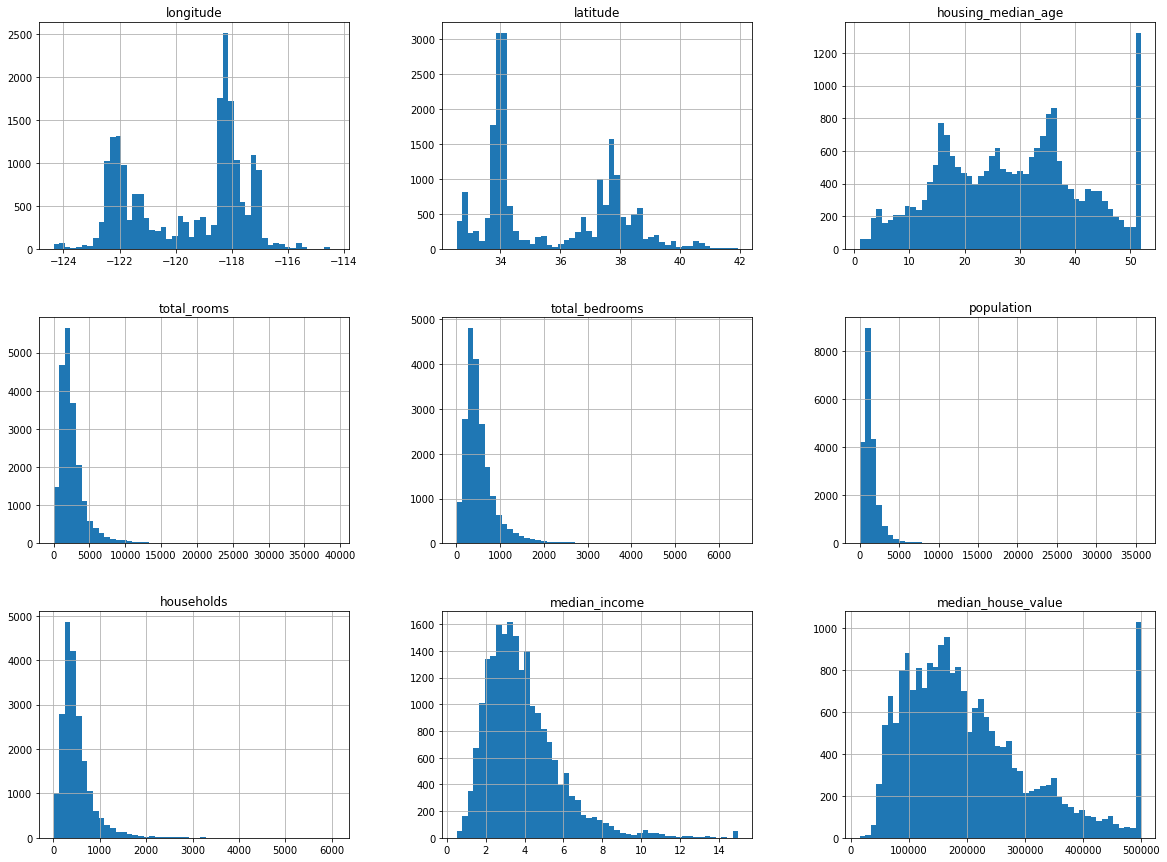

In [140]:
%matplotlib inline 
##uses jupyters own backend for inline plotting
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show() #optional

**Oberservations from plots:** <br/>
* housing median age, median income and median house value are preprocessed. <br />
* median income is scaled, value = value * tens of thousands -> 6 equals 60.000 USD <br />
* median house value was capped at 500k, ML algorithm might learn that house values do not exceed that price --> problem, as this is the target value of our task <br />
* median income also seems to be capped <br />
* differences in scaling <br />
* some are tail heavy - histograms extend more to the right of the median <br />
* avoid snooping bias from first impressions! <br/>

<h3>Creating a Test Set</h3>


In [141]:
import numpy as np

#function for splitting data into train set and test set 
#test ratio is percentage of data we want to keep for testing, often 20% (0.2)
def split_train_test(data, test_ratio): 
    #creates a random permutation of the numbers from 0 to len(data) to create random indices
    shuffled_indices = np.random.permutation(len(data))
    #test set size = 20 per cent (test_ratio) of dataset size
    test_set_size = int(len(data) * test_ratio) 
    
    test_indices = shuffled_indices[:test_set_size] #first 80% of shuffled indices
    train_indices = shuffled_indices[test_set_size:] #remaining 20% of shuffled indices
    
    #gets the districts by shuffled indices for train and test
    #"Purely integer-location based indexing for selection by position"
    #data.iloc gets as input a list of integers (first 80/last 20 per cent of shuffeled indices) and 
    #then "collects" all the districts that have those indices
    return data.iloc[train_indices], data.iloc[test_indices]

In [142]:
#when we call the function then we get a random split of the data into train and test
train_set, test_set = split_train_test(housing, 0.2)

In [143]:
len(train_set)


16512

In [144]:
len(test_set)


4128

**Problem: These two solutions are not stable as everytime we run the code again it will create a different train and test split and data that was in train before will go into test and vice versa.**

**Possible fixes (that we should not use):**
* save test set on first run and then load it in subsequent runs
* setting the seed of np.random.permutation so that it always generates the same shuffled indices

But also these will break if we want to fetch an updated dataset. We want to have a stable train/test split that remains stable also when updating the data.

**A common solution for this issue:**
* use each instance's identifier to decide whether or not they should go into the test set (assuming that each instance has a unique and immutable identifier)
* we have the option of computing a hash of each instance's identifier and decide whether it goes into train or test, based on the hash being f.e. higher or lower (lower/equal) than 20% of the max hash value.
* this ensures that even if we refresh the data set the new test set will contain 20% of the new instances, so it guarantees three things:
    * the "old" values stay in the test set
    * 20% of the new values are in the test set
    * no value from the train set will ever go into the test set
    
This is what an implementation of that principle looks like:

In [145]:
from zlib import crc32 

#zlib is a library for data compression
#zlib.crc32() method computes the unsigned 32-bit checksum for given data

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]


In [146]:
#the housing dataset does not have an identifier column, simple solution: using row index as id 
#however here have to always ensure that new data gets appended to the end of the dataset and no row is ever deleted

housing_with_id = housing.reset_index() #pandas function for adding index column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")



In [147]:
#alternative: using most stable features to build unique identifier
#f.e. longitude/latitude will remain stable; we can combine them into a unique id like so:

housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")



In [148]:
#scikit-learn provides some functions for data set splitting, simplest being train_test_split()
from sklearn.model_selection import train_test_split

#works similarly to split_train_test; offers feature to set a seed and to load multiple datasets of identical
#number of rows that it can then split on same indices (useful if we have f.e. labels seperately)

train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42)

We only split train and test so far using randomized methods - this can make our model prone to sampling bias, as we have not yet considered that our test set should be as representative as possible of the underlying dataset. Thus we will look at the data again in order to find important ratios *(strata)* that have to be maintained and reflected. This is called *stratified sampling*.

In this project we suppose that we have received information from experts that the median income is a very important factor for the prediction of housing prices. That means we have to look at the median income data and make sure that we have a sufficient amount of data for each *category* of income. Like that, we keep the train/test set representative of the whole dataset and lower the risk of the estimate of a stratum's importance being biased. We should have neither too many nor to few strata and they should each be big enough.

We are using pd.cut() for that purpose, a function that bins values into discrete intervals. Binning is a technique used in data processing and statistics. It describes class formation in pre-processing during data analysis. A given set of sorted values is divided into intervals (bins). Each of these intervals is then designated by a representative, also called interval labels. Binning is often used when there is more possible data than is actually needed - for example, body sizes of people can be divided into intervals or categories.



In [149]:
#adding an "income_cat" attribute to housing
#pandas.cut() takes the values from the "median_income" column, 
#https://pandas.pydata.org/docs/reference/api/pandas.cut.html
housing["income_cat"] = pd.cut(
                               #1D input array to be binned
                               housing["median_income"], 
                               #bins = sequence of scalars : defines bin edges allowing for non-uniform width
                               bins = [0, 1.5, 3, 4.5, 6, np.inf], 
                               #specifies the labels for the returned bins
                               labels = [1, 2, 3, 4, 5]
                        )


In [150]:
#OWN
#looking at "median_income" again just for clarification
housing["median_income"].max()

15.0001

In [151]:
#OWN
housing["median_income"].head(10)

0    8.3252
1    8.3014
2    7.2574
3    5.6431
4    3.8462
5    4.0368
6    3.6591
7    3.1200
8    2.0804
9    3.6912
Name: median_income, dtype: float64

In [152]:
#OWN
housing["income_cat"].head(10)
#just wanted to see if the income_cat column is there and what it looks like it is
#output also shows categories

0    5
1    5
2    5
3    4
4    3
5    3
6    3
7    3
8    2
9    3
Name: income_cat, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

<AxesSubplot:>

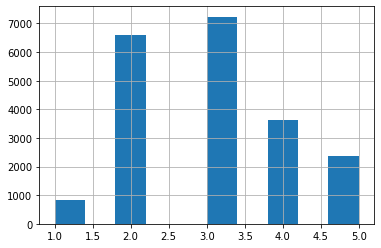

In [153]:
#gives a histogram of the categories that we have now
housing["income_cat"].hist()

Now we can start stratified sampling - we are using Scikit-Learn's StratifiedShuffleSplit class.
That is how we are going about it for this particular case - we should always look for what has to be prepared for stratification in every individual case, depending on the data at hand.

In [154]:
from sklearn.model_selection import StratifiedShuffleSplit

#StratifiedShuffleSplit Provides train/test indices to split data in train/test sets
#n_splits is the number of splittig iterations
#test_size defines the percentage of our dataset that we want to keep for testing
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index] #collects districts by index
    strat_test_set = housing.loc[test_index]



We can now take look at the income category proportions in the test set:

In [155]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

So about 2/3 of people belong to the categories 2 and 3.

This following code gives us a table that shows us the sampling bias comparison of startified versus purely random sampling:


In [156]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100


In [157]:
compare_props

Overall  Stratified    Random  Rand. %error  Strat. %error
1  0.039826    0.039729  0.040213      0.973236      -0.243309
2  0.318847    0.318798  0.324370      1.732260      -0.015195
3  0.350581    0.350533  0.358527      2.266446      -0.013820
4  0.176308    0.176357  0.167393     -5.056334       0.027480
5  0.114438    0.114583  0.109496     -4.318374       0.127011

Here we can see clearly that the stratified error is significantly smaller for each bin and also we can show an improvement in representation of proportions in the subset. Thus, we minimized the chance of sampling bias and will have a better base for our predictions later on.

Now we have to remove the income_cat attribute so the data goes back to it's original state:

In [158]:
#check if that attribute is in strat train set -> yes, last column
strat_train_set.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
17606    -121.89     37.29                38.0       1568.0           351.0   
18632    -121.93     37.05                14.0        679.0           108.0   
14650    -117.20     32.77                31.0       1952.0           471.0   
3230     -119.61     36.31                25.0       1847.0           371.0   
3555     -118.59     34.23                17.0       6592.0          1525.0   

       population  households  median_income  median_house_value  \
17606       710.0       339.0         2.7042            286600.0   
18632       306.0       113.0         6.4214            340600.0   
14650       936.0       462.0         2.8621            196900.0   
3230       1460.0       353.0         1.8839             46300.0   
3555       4459.0      1463.0         3.0347            254500.0   

      ocean_proximity income_cat  
17606       <1H OCEAN          2  
18632       <1H OCEAN          5  
14650      NEAR OCEAN          2  
3230           INLAND          2  
3555        <1H OCEAN          3

In [159]:
#same for test set -> also last column
strat_test_set.head()


longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
5241     -118.39     34.12                29.0       6447.0          1012.0   
10970    -117.86     33.77                39.0       4159.0           655.0   
20351    -119.05     34.21                27.0       4357.0           926.0   
6568     -118.15     34.20                52.0       1786.0           306.0   
13285    -117.68     34.07                32.0       1775.0           314.0   

       population  households  median_income  median_house_value  \
5241       2184.0       960.0         8.2816            500001.0   
10970      1669.0       651.0         4.6111            240300.0   
20351      2110.0       876.0         3.0119            218200.0   
6568       1018.0       322.0         4.1518            182100.0   
13285      1067.0       302.0         4.0375            121300.0   

      ocean_proximity income_cat  
5241        <1H OCEAN          5  
10970       <1H OCEAN          4  
20351       <1H OCEAN          3  
6568           INLAND          3  
13285          INLAND          3

In [160]:
#note to self: will give error if run multiple times as the axis will have been removed and thus not found
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [161]:
#now it should not be there anymore --> OK, it's not!

strat_train_set.head()


longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
17606    -121.89     37.29                38.0       1568.0           351.0   
18632    -121.93     37.05                14.0        679.0           108.0   
14650    -117.20     32.77                31.0       1952.0           471.0   
3230     -119.61     36.31                25.0       1847.0           371.0   
3555     -118.59     34.23                17.0       6592.0          1525.0   

       population  households  median_income  median_house_value  \
17606       710.0       339.0         2.7042            286600.0   
18632       306.0       113.0         6.4214            340600.0   
14650       936.0       462.0         2.8621            196900.0   
3230       1460.0       353.0         1.8839             46300.0   
3555       4459.0      1463.0         3.0347            254500.0   

      ocean_proximity  
17606       <1H OCEAN  
18632       <1H OCEAN  
14650      NEAR OCEAN  
3230           INLAND  
3555        <1H OCEAN

<h3>Discovering and Visualizing the Data to get Insights</h3>



We now have a general understanding of the data we are working with. To go a bit more in depth, we will now get a copy of the training set in order to gain deeper insights through the use of visualization methods.

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

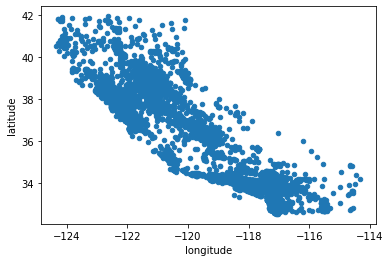

In [162]:
#getting the copy to not harm the original train set
#if the dataset is very large, it is also an option to sample an exploration set (a stratified subset)
housing = strat_train_set.copy()

"""due to the fact that we are working with geographical data we can nicely plot a scatterplot along the axes of 
longitude and latitude - resulting in a data cloud shaped like california."""

housing.plot(kind = "scatter", x = "longitude", y = "latitude")

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

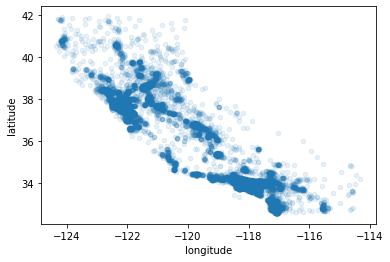

In [163]:
#setting alpha parameter (transparency) in order to better visualize density
#playing aroud with visualization parameters is great way to explore and find patterns
housing.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.1)

This plot visualizes the areas with higher density quite well: along the coast, Los Angeles, San Diego and Central Valley. These areas are even more pronounced when reducing alpha even a little further:

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

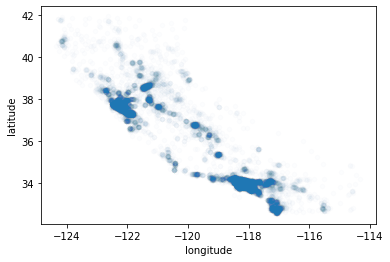

In [164]:
#OWN
housing.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.01)

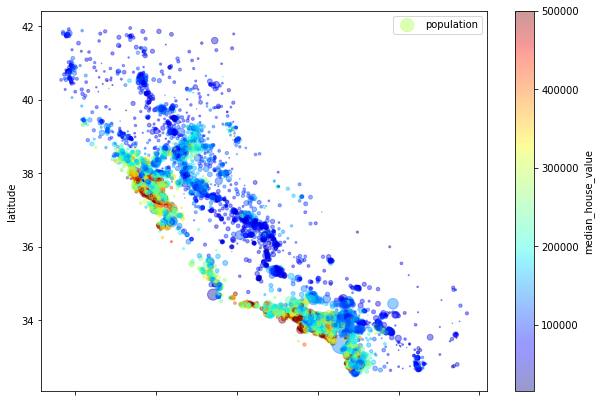

In [165]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.4, 
             #option s makes size of each circle represent the districts population size
             s = housing["population"]/100, label = "population", figsize = (10,7),
             #option c makes the colors represent the prices
             #for this we use predefinded colormap "jet" raning from low (blue) to high prices(red)
             c = "median_house_value", cmap = plt.get_cmap("jet"), colorbar = True
)

plt.legend()

What general trends does the image show us?

* the highest prices tend to be along the coast - this indicates ocean proximity to be an influential factor
* the lowest prices tend to be more in areas of lower population density, more inland
* a general trend seems to be that the further away from the ocean, the less expensive housing becomes
* housing seems to be more expensive in the bigger cities 
* the combination of proximity to bigger cities and the ocean seems to increase housing prices
    * we do not have a "proximity to bigger city" attribute, but I think it very likely that if we had it it would help
    * in the north, housing prices acoording to this theory may be lower even when bay proximity is high, as there are no bigger cities close by


<h3>Looking for Correlations</h3>

We are now using the corr() method to look for correlations (standard correlation coefficient, "Pearson's r"):

In [166]:
#OWN
#wanted to see the whole matrix and limited the decimals for better readability
corr_matrix = pd.DataFrame(housing.corr())
corr_matrix = corr_matrix.round(decimals = 2)

#in jupyter use display here instead of print
display(corr_matrix)


longitude  latitude  housing_median_age  total_rooms  \
longitude                1.00     -0.92               -0.11         0.05   
latitude                -0.92      1.00                0.01        -0.04   
housing_median_age      -0.11      0.01                1.00        -0.36   
total_rooms              0.05     -0.04               -0.36         1.00   
total_bedrooms           0.08     -0.07               -0.33         0.93   
population               0.11     -0.12               -0.30         0.86   
households               0.06     -0.08               -0.31         0.92   
median_income           -0.02     -0.08               -0.11         0.20   
median_house_value      -0.05     -0.14                0.11         0.14   

                    total_bedrooms  population  households  median_income  \
longitude                     0.08        0.11        0.06          -0.02   
latitude                     -0.07       -0.12       -0.08          -0.08   
housing_median_age           -0.33       -0.30       -0.31          -0.11   
total_rooms                   0.93        0.86        0.92           0.20   
total_bedrooms                1.00        0.88        0.98          -0.01   
population                    0.88        1.00        0.90           0.00   
households                    0.98        0.90        1.00           0.01   
median_income                -0.01        0.00        0.01           1.00   
median_house_value            0.05       -0.03        0.06           0.69   

                    median_house_value  
longitude                        -0.05  
latitude                         -0.14  
housing_median_age                0.11  
total_rooms                       0.14  
total_bedrooms                    0.05  
population                       -0.03  
households                        0.06  
median_income                     0.69  
median_house_value                1.00

How much does each attribute correlate with our target "median_house_value"?

In [167]:
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value    1.00
median_income         0.69
total_rooms           0.14
housing_median_age    0.11
households            0.06
total_bedrooms        0.05
population           -0.03
longitude            -0.05
latitude             -0.14
Name: median_house_value, dtype: float64

Observations:
* median income seems to be an important factor with a correlation of about 0.7
* next biggest but small correlation of about 0.1/-0.1 with total rooms, housing median age and latitude
* I think the lower negative latitude correlation can be explained with that lower latitude values indicate more closeness to the coast, and the coast tends to have higher housing prices.



As we have 11 numerical attributes, printing them all against each other would result in 11² = 121 plots. We will accordingly now focus on the most promising attributes and check for correlations using the pandas scatter_matrix() function.

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

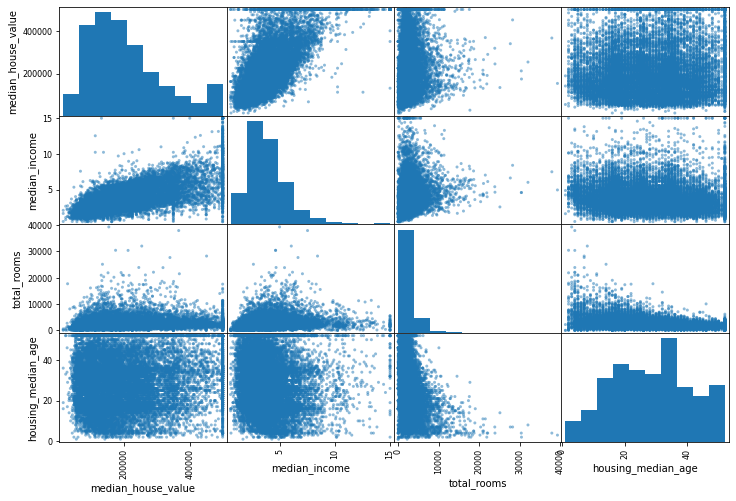

In [168]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize = (12,8))

#the diagonal would just plot each attribute against itself, so pandas displays a histogram of the respective ...
#... attribute there (by default at least, there is more options, look into documentation)

Observations:
* tail heavy data
* positive correlations in med income and med house value in both directions

<AxesSubplot:xlabel='median_house_value', ylabel='latitude'>

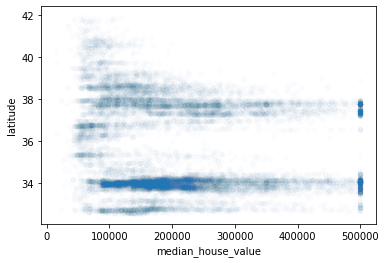

In [169]:
#OWN
#wanted to see the correlation with latitude visualized, just for fun
housing.plot(kind = "scatter", x = "median_house_value", y = "latitude", alpha = 0.01)

* doesn't look great but we can see that higher latitude means lower number of high housing prices.

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

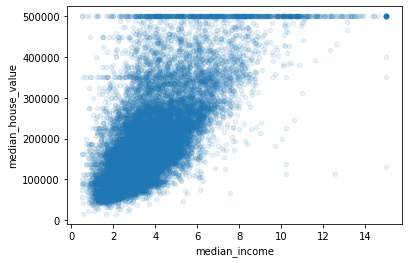

In [170]:
#median income vs median house value has a clear positive correlation, so we will zoom in on it
housing.plot(kind = "scatter", x = "median_income", y = "median_house_value", alpha = 0.1)

Observations:

* clear upward trend, not too much dispersion
* line at 500k as data was capped
* more, less obvious lines at about 460k, 350k, 280k - data quirks that should be removed so our algorithm doent learn them (--> it is not shown in the book how to do that)

We will need to do some data cleaning soon, but we will now first play with attribute combinations and create some new attributes. Some of the given ones such as population, total number of bedrooms or total rooms are not very useful by themselves, but as we have good reason to assume that combining them will increase the amount of information that we can get from them about a disrict, that is what we will now do:

In [171]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

#looking at correlation with target value
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

<AxesSubplot:xlabel='median_house_value', ylabel='bedrooms_per_room'>

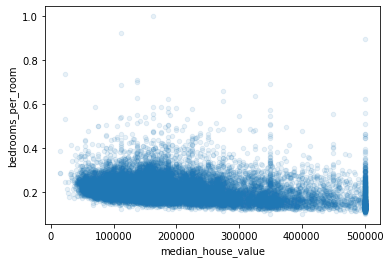

In [172]:
#OWN
#plotting the correlation between bedrooms_per_room and median_house_value

housing.plot(kind = "scatter", x = "median_house_value", y = "bedrooms_per_room", alpha = 0.1)

We gained some higher correlation through the new attribute "bedrooms per room". That is quite intuitive. I think the correlation is still relatively small because even though small or inexpensive houses have more bedrooms per room and expensive houses tend to have more rooms in general, they also tend to have more bedrooms.

This phase was for exploring and giving us some initial ideas in order to develop a first reasonably good prototype. These processes most of the time are kind of iterative anyways, and we can and often have to return to this type of step from that prototype to do more or more specific exploration if necessary.

<h3>Preparing Data for ML Algorithms</h3>
    
<h4> Data Cleaning</h4>

Instead of preparing the data manually we should write functions or use what e.g. *scikit-learn* provides already. This allows reproduction on other datasets, gradually builds a library of transformation functions to get back to in the future and makes it easy to compare different kinds of transformations. 

Fistly we will get a new copy of strat_train_set and seperate the labels. Like this we maintain the freedom of applying different transformations to predictor and target values.

In [173]:
#drop here creates copy of the data without the target value
#does not affect strat_train_set, and that copy is then stored in "housing"
housing = strat_train_set.drop("median_house_value", axis = 1)
housing_labels = strat_train_set["median_house_value"].copy()

#OWN, just wanted to see
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
17606    -121.89     37.29                38.0       1568.0           351.0   
18632    -121.93     37.05                14.0        679.0           108.0   
14650    -117.20     32.77                31.0       1952.0           471.0   
3230     -119.61     36.31                25.0       1847.0           371.0   
3555     -118.59     34.23                17.0       6592.0          1525.0   

       population  households  median_income ocean_proximity  
17606       710.0       339.0         2.7042       <1H OCEAN  
18632       306.0       113.0         6.4214       <1H OCEAN  
14650       936.0       462.0         2.8621      NEAR OCEAN  
3230       1460.0       353.0         1.8839          INLAND  
3555       4459.0      1463.0         3.0347       <1H OCEAN

As most ML algorithms do not work properly with missing features, we will now have to take care of those, as we discovered earlier that the total_bedrooms attribute contained NULL-valued entries.

Generally, we have three options:
* remove the affected districts
* remove the entire attribute
* set the values to something (median, mean, mode, zero....)
    

In general, we should rather stay away from removing data or attributes, unless we have no doubt that the attribute does not contain any valuable information for our problem. Removing entire entries we should only do if we have LOTS of data and the risk of biasing the results is low (especially when it affects a whole "cluster" rather than random entries "here and there", we will have higher risk of biasing). Also we can consider it if there is for example more missing in the entry than just one attribute value. Still, it should rather be avoided if possible.

When researching the topic further by myself, I found that *regression analysis* is another common approach to filling in these missing values - it can be used to predict the nullvalued entry using other information from the dataset. That will only work if the dataset is well connected. Also I found that depending on the nature of the dataset, the number of missing or faulty entries and/or how the data was gathered, we can manually fill them in. If the effort is justifiable, you can do your own research if you find another reliable source for the data or ask the people who gathered/produced it.

The three aforementioned options from above we can put into action with DataFrames' *dropna(), drop() and fillna()* methods:

In [174]:
#option 1: getting rid of corresponding districts -> not doing that
#housing.dropna(subset = ["total_bedroons"]) 
#option 2: dropping entire attribute --> not doing that either
#housing.drop("total_bedrooms", axis = 1) 

#option 3, calc median and replace nullvals with it
median = housing["total_bedrooms"].median() 
housing["total_bedrooms"].fillna(median, inplace = True)

Scikit-Learn provides us with a class called *SimpleImputer* that helps us take care of missing values:

In [175]:
from sklearn.impute import SimpleImputer 
#https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html

#we have to firstly create a SimpleImputer instance, specifying that we want to replace each missing value with...
#...the median of the corresponding attribute
imputer = SimpleImputer(strategy = "median") #set mean by default

#median only works for numerical attributes, so create copy of the data without ocean_proximity (text attribute)
housing_num = housing.drop("ocean_proximity", axis = 1)

#now we can fit the imputer instance to the training data using the fit() method
imputer.fit(housing_num)


SimpleImputer(strategy='median')

The imputer has computed the median of each attribute and stored it in it's *statistics_* instance variable.

As we cannot be sure that there will not be new null-valued entries in new data that we might add later, we should always apply the imputer to all numerical data that we get.

In [176]:
#looking at the imputer's statistics_ attribute here
#it gives us an array containing the imputation fill value for each feature
#so the 5th value (index 4) is the median for the total_bedrooms which can be used to fill the missing ones
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [177]:
#we can also get them this way
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

Now that we trained the imputer we can use it to transform the dataset by replacing the values that are missing with the learned medians:

In [178]:
X = imputer.transform(housing_num)

#result is a plain numpy array that contains the transformed features. Lets put it back into a pandas DataFrame:
#columns = column labels to use for resulting frame, defaulting to RangeIndex(0, 1, 2, …, n)
#index = index to use for resulting frame, defaultingto RangeIndex if none provided

housing_tr = pd.DataFrame(X, columns = housing_num.columns, index = housing_num.index)



<h4>Handling Text and Categorical Attributes</h4>

Our attribute "ocean_proximity" is non-numerical:

In [179]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

ocean_proximity
17606       <1H OCEAN
18632       <1H OCEAN
14650      NEAR OCEAN
3230           INLAND
3555        <1H OCEAN
19480          INLAND
8879        <1H OCEAN
13685          INLAND
4937        <1H OCEAN
4861        <1H OCEAN

As there is a limited number (5) of distinctionable values for ocean proximity, this is a categorical attribute. Because it is better to work with numbers for most ML Algorithms, we will now convert the text to numbers using Scikit-Learn's *OrdinalEncoder* class.

In [180]:
from sklearn.preprocessing import OrdinalEncoder

#housing_cat = housing[["ocean_proximity"]] is defined before 

#creating an instance of ordinal encoder
ordinal_encoder = OrdinalEncoder()

housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10] #shows us the first ten categorical values, each number 0-4 stands for a category

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [181]:
#show list of categories by accessing the ordinal_encoder instance's categories_attribute that saves the categories
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

**Possible problem:** this representation might make the ML algorithm "assume" that two nearby values are more similar than those further apart, which does not make sense in our case. Thus, we will use a binary matrix representation instead.

In [182]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()

housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [183]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [184]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

If a categorical attribute has a large number of possible categories, one-hot-encoding will result in a large number of input features. This can slow down training and degrade performance. 

Such categorical attributes can be postal codes, species, brands and other things that by nature have a larger space of permutations.

A possible way to address this is to transform the affected attributes, for example instead of "near ocean" or "island" it would make sense to, as an idea, instead use *distance to ocean* in miles/km. That is the preferable way of doing it - if it is possible.

Alternatively, we can replace each category with a learnable, low-dimensional vector called an *embedding*. Each categoriy's representation will then be learned during training (this is an example of something called *representation learning* --> will be adressed later in the book).

<h4>Custom Transformers</h4>

Although Scikit-Learn provides us with many useful transformers, we will sometimes need to write our own, especially because we often need data-specific cleanup operations, or when we want to combine specific attributes into new attributes. 

Since Scikit-Learn relies on duck typing, all we will have to do is create a class and write three methods:
* fit(), returning self
* transform()
* fit_transform() which we can get for free by simply adding *TransformerMixin* as a base class

If we also add BaseEstimator as a base class, we will also get the two extra methods get_params() and set_params(), useful for automatic hyperparameter tuning (if we avoid *args and ** kargs in our constructor).

This is an example of a small transformer class that adds the combined attributes we used earlier:

In [185]:
from sklearn.base import BaseEstimator, TransformerMixin

"""BaseEstimator is a base class for estimators from which all other estimators inherit. They specifically inherit 
getParams() and setParams().

A mix-in class is an extra class that we can use to "mix in" some further functionality. TransformerMixin thus is 
a mix-in class for all transformers in Scikit-Learn."""

#look at cell 38 for reference. we wanted bedrooms per rooms, rooms per household and population per household
#thus these four attributes are used here
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6


#CombinedAttributesAdder inherits from BaseEstimator and TransformerMixin
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    
    """__init__ is a constructor method
    This method is called when an object is created from the class and it allows the 
    class to initialize the attributes of a class."""
    
    def __init__(self, add_bedrooms_per_room = True): #no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y = None):
        return self #nothing else to do
    
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]

        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
    
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room = False)
housing_extra_attribs = attr_adder.transform(housing.values)



* in this example the transformer has one hyperparameter, add_bedrooms_per_room, set True by default
* this hyperparameter will allow to easily find out whether adding this attribute helps the ML algorithm or not, more generally: we can add a hyperparameter to gate any data preparation step that we are not 100% sure about yet
* the more we automate these data prepping steps, the more combinations we can automatically try out
* by this we increase likelihood of finding really good combinations and save lots of time


<h4>Feature Scaling</h4>

One of the most important transformations we need to apply is *feature scaling*.

Most ML algorithms do not perform well when the input numerical attributes have very different scales.
In our case, the values of "total_number_of_rooms" range from about 6 to 39.320, while median incomes only range from 0 to 15 (the median income was preprocessed, now wach value stands for tens of thousands).

Note that scaling the target value us usually not required.

There are two common ways to get all attributes to have the same scale: **Min-Max-Scaling and Standardization**.

* **Min-Max-Scaling:**
    * also called normalization, simplest approach
    * values are shifted and rescaled so that they range from 0 to 1
    * done by subtracting the min value and dividing by the max minus the min
    * scikit-learn provides a transformer named min-max-scaler for this, having a feature_range hyperparameter that lets us adjust the range (if we dont want 0-1)

* **Standardization:**
    * standardized data always has a zero mean
    * first subtracts mean value and then divides by the standard deviation so that the resulting distribution has unit variance
    * unlike min-max-scaling, standardization is not bound to a specific range --> can be a problem for some algorithms that expect that (neural networks often expect values in range 0-1)
    * standardization is less susceptible to outliers:
        * if for example by accident a median income for a district was set to 100, min-max-scaling would scale down all other values from 0-15 to 0-0.15
        * standardization would not be much affected by this.
    * scikit-learn provides us with a transformer called *StandardScaler* for standardization
    
As with all transformations, we have to make sure to fit the scalers to the training data only, not to the full dataset (i.e. we should not include the test set). Only then we can use them to transform the training set and the test set (and new data).

<h4>Transformation Pipelines</h4>

As there are many data transformation steps that need to be executed in a particular order, Scikit-Learn provides the *Pipeline* class to make these sequences of transformations easier and more convenient. If it was not for this, we would have to retype the execution (which also degrades code quality) or write our own function for that. This is a small pipeline for the numerical attributes:

In [186]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#pipeline constructor takes a list of name/estimator pairs defining a sequence of steps
#all but the last estimator must be transformers (i.e. must have a fit_transform() method)
#names can be anything we like, will be used later for hyperparameter tuning

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = "median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])
    
housing_num_tr = num_pipeline.fit_transform(housing_num)
    

* When we call the pipeline's *fit()* method, it calls fit_transform() sequentially on all transformers,
passing the output of each call as the parameter to the next, until it reaches the final estimator. For the 
final estimator it then calls the *fit()* method.

* The pipeline exposes same methods as the final estimator (in our example *StandardScaler()*) 
    * as that is a transformer, the pipeline has a transform() method that applies all transforms to the data in sequence (and of course also a fit_transform, which we are using here).
    
As we have handled the columns of numerical and categorical data seperately, it would be more convenient to have a single transformer to handle it all, applying the appropriate transformations to each column.

Fot this, Scikit-Learn provides the *ColumnTransformer*, which also works well for *Pandas DataFrames*, as used in this project. 

This is an application of that on our housing data:

In [187]:
from sklearn.compose import ColumnTransformer

#first we import the Column Tansformer class
#then we get the list of numerical column names and categorical column names (we have just one, ocean_proximity)

num_attribs = list(housing_num) #list of dataframe returns first row 
cat_attribs = ["ocean_proximity"]

"""
- constructing a column transformer
- the constructor requires a list of tuples  
- each tuple contains a name, a transformer and a list of names or indices of columns that the transformer should be
applied to

In this example we specify that the numerical columns should be transformed using the num_pipeline that we defined 
earlier and the categorical columns should be transformed using OneHotEncoder

"""

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])

"""Finally, we apply this ColumnTransformer to the housing data: it applies each transformer to the appropriate 
columns and concatenates the outputs along the second axis (the transformers must return same number of rows).

Note: OneHotEncoder returns a sparse matrix while the num_pipelines returns a dense matrix. When there is a mix of 
sparse and dense matrices, the ColumnTransformer estimates the density of the final matrix (ratio of nonzero cells) 
and it returns a sparse matrix if the density is lower than a given threshold (default sparse_threshold = 0.3).
"""

housing_prepared = full_pipeline.fit_transform(housing)


Now we have a preprocessing pipeline that takes the full housing data and applies the appropriate 
transformation to each column.

Alternatively we can specify the string *drop* to drop the columns or *passthrough* to leave them untouched. Also look at the *remainder* parameter, we can set it to any transformer alternatively.

<h3>Select and Train a Model</h3>

<h4>Training and Evaluating on the Training Set</h4>

In [188]:
#OWN
#displaying dataframe of housing_prepared to see what it looks like now
display(pd.DataFrame(housing_prepared))

0         1         2         3         4         5         6   \
0     -1.156043  0.771950  0.743331 -0.493234 -0.445438 -0.636211 -0.420698   
1     -1.176025  0.659695 -1.165317 -0.908967 -1.036928 -0.998331 -1.022227   
2      1.186849 -1.342183  0.186642 -0.313660 -0.153345 -0.433639 -0.093318   
3     -0.017068  0.313576 -0.290520 -0.362762 -0.396756  0.036041 -0.383436   
4      0.492474 -0.659299 -0.926736  1.856193  2.412211  2.724154  2.570975   
...         ...       ...       ...       ...       ...       ...       ...   
16507  0.722267 -0.673331  1.379547 -0.632123 -0.725361 -0.759010 -0.764049   
16508  1.007011 -0.823004  0.902385 -0.667196 -0.584183 -0.329664 -0.636291   
16509  1.586489 -0.724781 -1.562952  1.043901  0.822735  0.607904  0.713156   
16510  0.782213 -0.851068  0.186642 -0.309919 -0.374849 -0.057178 -0.375451   
16511 -1.435791  0.996459  1.856709  0.220853  0.360253 -0.135159  0.377791   

             7         8         9         10   11   12   13   14   15  
0     -0.614937 -0.312055 -0.086499  0.155318  1.0  0.0  0.0  0.0  0.0  
1      1.336459  0.217683 -0.033534 -0.836289  1.0  0.0  0.0  0.0  0.0  
2     -0.532046 -0.465315 -0.092405  0.422200  0.0  0.0  0.0  0.0  1.0  
3     -1.045566 -0.079661  0.089736 -0.196453  0.0  1.0  0.0  0.0  0.0  
4     -0.441437 -0.357834 -0.004194  0.269928  1.0  0.0  0.0  0.0  0.0  
...         ...       ...       ...       ...  ...  ...  ...  ...  ...  
16507  0.554158  0.234352 -0.031755 -0.428853  0.0  1.0  0.0  0.0  0.0  
16508 -0.948815 -0.308114  0.084689  0.491503  0.0  1.0  0.0  0.0  0.0  
16509 -0.316705  0.346934 -0.030554 -0.521776  0.0  1.0  0.0  0.0  0.0  
16510  0.098121  0.024995  0.061509 -0.303407  1.0  0.0  0.0  0.0  0.0  
16511 -0.157799 -0.228529 -0.095863  0.101806  0.0  0.0  0.0  1.0  0.0  

[16512 rows x 16 columns]

Columns 11 to 15 are the sparse matrix representing the "ocean_proximity" categorical attribute we created by using *OneHotEncoder.*

In [189]:
display(pd.DataFrame(housing_labels))

median_house_value
17606            286600.0
18632            340600.0
14650            196900.0
3230              46300.0
3555             254500.0
...                   ...
6563             240200.0
12053            113000.0
13908             97800.0
11159            225900.0
15775            500001.0

[16512 rows x 1 columns]

As we did all the preprocessing thoroughly, the next steps will be simpler now. We will now train a linear regression model:

In [190]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

#now we have a working linear regression model. Let's try them out on a few instances:

some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

#show predicted labels
predictions = lin_reg.predict(some_data_prepared)
labels = list(some_labels)

print("Predictions:", predictions)
print("Labels:", labels)


Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [191]:
#OWN
#getting a little overview by how many percent the predictions are off from the actual values
off = 1 - (lin_reg.predict(some_data_prepared)/list(some_labels))
off *= 100

for i in range(len(list(some_labels))):
    print("Label ", i, " is ", labels[i], " and prediction is", predictions[i], ", off by", -off[i], "%")
    
print("For the first 5 rows, the values are off (looking at abstract) by on average", abs(off).mean(), "%")

Label  0  is  286600.0  and prediction is 210644.60459285555 , off by -26.502231474928283 %
Label  1  is  340600.0  and prediction is 317768.8069721082 , off by -6.703227547824953 %
Label  2  is  196900.0  and prediction is 210956.4333117823 , off by 7.1388691273653215 %
Label  3  is  46300.0  and prediction is 59218.98886849065 , off by 27.902783733241133 %
Label  4  is  254500.0  and prediction is 189747.55849878513 , off by -25.443002554504858 %
For the first 5 rows, the values are off (looking at abstract) by on average 18.73802288757291 %


It works, but the predictions are not very accurate. If you compare the first value (prediction 210644, actual 286600), you see that the prediction is off by almost -30 per cent.

Let us measure this regression model's *mean squared error* on the **whole** training set using Scikit-Learn's *mean_squared_error* function:

In [192]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse


68628.19819848923

This value shows that, while most district's median_housing_value ranges between 120000 and 265000 USD, we have an average prediction error of more than 68000 USD. 

This seems to be a case of underfitting. When this happens, it can mean that the features do not provide enough information to make good predictions, or that the model is not powerful enough.

The common approaches to fixing underfitting are:
* selecting a more powerful model
* feeding the algorithm with better features
* reducing the constraints on the model (ruled out because the model is not regularized)

We could add more features like the logarithm of the population, but first we will try a more powerful model to see how it performs compared to Linear Regression.

We are now trying a DecisionTreeRegressor, a powerful model that is capable of finding complex nonlinear relationships in the data:



In [193]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

#now that the model is trained, let's evaluate it on the training set

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

The error is zero, so we have probably overfit the data.

As we have seen earlier, we do no want touch the test set until we are ready to launch a model that we are confident about. Thus, we will need to use part of the training set for training and part of it for model validation.

<h4>Better Evaluation using Cross Validation</h4>

One way to evaulate the Decision Tree model would be using train_test_split. We could split the training data into a train and a validation set and accordingly leave the actual test set untouched. Then we could train our models against the smaller training set and evaluate them against the validation set. 

Even though that would work and is not very elaborate, we can instead use Scikit-Learn's *k-fold-cross validation* feature.

The following code does a random split into 10 distinct folds, then trains and evaluates the Decision Tree model 10 times, and in each of them picks a different fold for evaluation and trains on the remaining 9 folds.

The result is an array containing the 10 evaluation scores:


In [194]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv = 10)
tree_rmse_scores = np.sqrt(-scores)

"""sklearns crossvalidation features expect a utility function (greater is better) rather than a cost function (lower 
is better), so the scoring function is acutally te opposite of the MSE (i.e. a negative value) which is why the 
preceding code computes negative sign scores before calculating the square root"""

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())
    
display_scores(tree_rmse_scores)

Scores: [69810.62085516 66747.4952576  71540.80185136 69917.81779333
 70616.50559745 75142.49672919 70910.82106216 72061.56042927
 77932.88230704 70252.17471892]
Mean: 71493.31766014769
Standard Deviation: 2925.657044792075


* does not look as good as it did earlier
* seems to perform even worse than linear regression
* cross validation does not only give us an estimate of the performance of the model but also a measure of how precise this estimate is (i.e. its standard deviation)
* the decision tree has a score of approximately 71407, generally +/- the value of standard deviation 

My standard deviation value is different from the one in the book, I think it's because the folds are random and consequently in every run.

Looked into it --> seems like it, it gives different values when running again. Question to clarify: why are the folds not stratified? Is it a thing to do that?

EDIT: Yes, it's a thing: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html 


In [195]:
#Lets compute the same values from the linear regression model:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv = 10)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard Deviation: 2731.674001798342


They perform about equally bad, in the book the standard deviation for linear regression is significantly larger for linear regression than for the decision tree. The decision tree overfits badly and accordingly performs badly, just like the underfitting in the linear model.


* We are trying one last model now, the *RandomForestRegressor.*
* Random forests work by training many random decision trees on random subsets of the features and then average out the predictions
* building a model on top of other models is called *Ensemble Learning* and is often a great way to push ML algorithm performance even further


In [196]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)


RandomForestRegressor()

In [197]:
housing_predictions = forest_reg.predict(housing_prepared)

forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18787.723547640453

In [198]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [49484.27695955 47346.53486005 50068.86905768 52695.56485244
 49521.94917788 53430.52294538 48719.64384482 47641.55917318
 53062.01597861 50582.18124165]
Mean: 50255.31180912423
Standard Deviation: 2069.7649929830986


* much better - random forests seem promising
* however, the score on the traning set is still much lower than on the validation sets, meaning that the model still overfits the training set
* possible solutions:
    * simplify the model
    * constrain (regularize) it
    * get a lot more training data
* instead of fixing on this model, we should always try out many different models more from different categories of ML algorithms (like several SVMs with different kernels, a neural network, ...) without spending too much time tweaking the hyperparameters
* <mark>GOAL: shortlisting a few promising models (2 to 5)</mark>

* we should always save any model we try so we can easily get back to it if needed
    * make sure to save both hyper and trained parameters as well as the cross validation scores and perhaps the actual predictions as well
    * we can use Python's *pickle* module for that, or use the *joblib* library (more efficient at serializing large NumPy arrays)
    
**Code for getting joblib:**

import joblib
joblib.dump(my_model. "my_model.pkl")

...and later <br>
my_model_loaded = jobib.load("my_model.pkl")

<h3>Fine-Tuning the Model</h3>

Assuming that we have a shortlist of promising models, we now need to fine-tune them. Here are a few ways to do that:

<h4>Grid Search</h4>

* as experimenting with hyperparameters manually is a lot of work and would not likely yield optimal results, we can use Scikit-Learn's *GridSearchCV* 
* we only need to tell it which hyperparameters we want it to experiment with and what values to try out 
* it will use cross validation to evaluate all possible combinations of hyperparamenter values

The following code for example shows us the best combination of hyperparameter values for the *RandomForestRegressor*:

In [199]:
from sklearn.model_selection import GridSearchCV

"""param_grid tells scikit-learn to first evaluate all 3x4 = 12 n_estimator and mac_feature parameter values
as specified in the first dict.

Then try all 2x3 = 6 combinations of hyperparameter values in the second dict, but this time with the bootstrap
hyperparameter set to false instead of true (true is default).

Thus the grid search will explore 12 + 6 = 18 combinations of hyperparameter values for RandomForestRegressor and 
will train each model 5 times (as we are using 5 fold cross validation). That means there will ne 18*5 = 90 rounds
of training --> may take a bit longer!
"""

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [200]:
#getting the best parameter combination
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [201]:
#we can also get the best estimator directly
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)

If GridSearchCV is initialized with *refit = True* (default), then once the best estimator is found using cross validation, it retrains the whole training set.

This is usually a good idea, since feeding it more data will likely improve the performance.

In [202]:
#evaluation scores are also available
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63669.11631261028 {'max_features': 2, 'n_estimators': 3}
55627.099719926795 {'max_features': 2, 'n_estimators': 10}
53384.57275149205 {'max_features': 2, 'n_estimators': 30}
60965.950449450494 {'max_features': 4, 'n_estimators': 3}
52741.04704299915 {'max_features': 4, 'n_estimators': 10}
50377.40461678399 {'max_features': 4, 'n_estimators': 30}
58663.93866579625 {'max_features': 6, 'n_estimators': 3}
52006.19873526564 {'max_features': 6, 'n_estimators': 10}
50146.51167415009 {'max_features': 6, 'n_estimators': 30}
57869.25276169646 {'max_features': 8, 'n_estimators': 3}
51711.127883959234 {'max_features': 8, 'n_estimators': 10}
49682.273345071546 {'max_features': 8, 'n_estimators': 30}
62895.06951262424 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54658.176157539405 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59470.40652318466 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52724.9822587892 {'bootstrap': False, 'max_features': 3, 'n_estimators'

* in this example we obtain the best solution by setting the *max_features* hyperparameter to 8 and the *n_estimators* hyperparameter to 30
* the RMSE score for this combo is 49 682, which is slightly better than the score we got earlier with the default hyperparameter values (which was 50 182).

* consider that we can treat some data preparation steps as hyperparameters:
    * f.e. grid search will automatically find out whether or not to add a feature we were not sure about, like the add_bedrooms_per_room hyperparameter of our *CombinedAttributesAdder* transformer.
    
* it may similarly well be used as a way to find outliers and missing features, feature selection, and more

<h4>Randomized Search</h4>

* grid search approach works fine when exploring relatively few combinations like in previous example
* but: when hyperparameter space increases search space increases as well
* it is often preferable to use *RandomizedSearchCV* instead:
    * this class can be used like *GridSearchCV* class, but instead of trying out all possible combos, it evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration
    * two main benefits:
        * if we let the randomized search run for (example) 1000 iterations, this approach will explore 1000 different values for each hyperpatameter (instead of just a few values per hyperparameter with the grid search approch)
        * simply by setting the number of iterations, we gain more control over the computing budget we want to allocate to hyperparameter search
 


<h4>Ensemble Methods</h4>

* another way of fine-tuning is trying to combine the models that perform best (a group of models, "ensemble")
* the ensemble often performs better than the best individual model (like RandomForest was better than individual decision tree it relies on), especially if the individual models create very different types of errors 

<h4>Analyzing the Best Models and Their Errors</h4>

In [203]:
#we can often gain interesting insights on the problem at hand by deeper inspection of the best models
#f.e.RandomForestRegressor can indicate the relative importance of each attribute for making accurate predictions:

feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03])

In [204]:
#lets display the importance scores next to their corresponding attribute names:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse = True)

[(0.36615898061813423, 'median_income'),
 (0.16478099356159054, 'INLAND'),
 (0.10879295677551575, 'pop_per_hhold'),
 (0.07334423551601243, 'longitude'),
 (0.06290907048262032, 'latitude'),
 (0.056419179181954014, 'rooms_per_hhold'),
 (0.053351077347675815, 'bedrooms_per_room'),
 (0.04114379847872964, 'housing_median_age'),
 (0.014874280890402769, 'population'),
 (0.014672685420543239, 'total_rooms'),
 (0.014257599323407808, 'households'),
 (0.014106483453584104, 'total_bedrooms'),
 (0.010311488326303788, '<1H OCEAN'),
 (0.0028564746373201584, 'NEAR OCEAN'),
 (0.0019604155994780706, 'NEAR BAY'),
 (6.0280386727366e-05, 'ISLAND')]

Here we see that apparently "median_income", the ocean_proximity category "INLAND" and "population_per_houshold" seem more important. We may want to try dropping some of the less useful features.
We should also try to understand the specific errors that our system makes, then try understanding why it makes those particular ones and figure out ways to fix the underlying problem (like adding extra features, getting rid of those which contain little information, dealing with outliers).

<h4>Evaluating Our System on the Test Set</h4>

After tweaking our models for a while, we should have a system that performs sufficiently well - now it's time to evaluate the system on the test set:
* get the predictors and the labels from the test set
* run full_pipeline
* evaluate on test set

Like this:



In [205]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis = 1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [206]:
final_rmse

47730.22690385927

* in some cases such a point estimate of the generalization error will not be enough to convince oneself to launch
    * what if it is just 0.1 per cent better than the model currently in production?
* we might want to have an idea of how precise this estimator is
* for this we can compute a *95% confidence interval* for the generalization error using scipy.stats.t.interval():

In [207]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors)-1,
                        loc = squared_errors.mean(),
                        scale = stats.sem(squared_errors)))

array([45685.10470776, 49691.25001878])

* if one did a lot of hyperparameter tuning, the performance will usually be slightly worse than what we measured using cross-validaion (reason being that the system ends up fine-tuned to perform well on the validation data and will likely not perform as well on unknown datasets)
* not the case in this example
* if it happens, one should not tweak the hyperparameters to make the numbers look better, as that will likely result in bad generalization on new data

NEXT: prelaunch phase
* presenting our solution:
    * highlighting what we learned
    * what worked, what did not work?
    * what assumptions were made?
    * what are our system's limitations?
* document everything
* create nice presentation with clear visualizations and easy-to-remember statements ("median income is the main predictor for housing prices")

In our *California Housing* example, the final performance is not better than the expert's price estimates, which were often off by about 20%, but it might still be useful as it frees up some time for the experts that they can use for other tasks.


<h4>Launching, Monitoring and Maintaining the System</h4>

* We now need to get our solution ready for production:
    * polish code
    * documententation and tests
* after that is done we can deploy the model to our production environment

**Examplatory ways of doing that:**
* **1: saving the trained Scikit-Learn-Model (f.e. using joblib) including the full preprocessing and prediction pipeline, then load this trained model within the production environment and use it to make predictions by calling its predict() method**


* **2: a real life application of the model can be its being used within a website** 
* user types in some data about a new district, clicks "estimate price" button which sends a query containing the data to a web server which forwards it to a web application, and finally our code will simply call the models predict() method


* **3: we can wrap the model within a dedicated web serice that our web application can query through a REST APO:**
    * makes it easier to upgrade the model to new versions without interrupting the main application
    * simplifies scaling also, since we can start as many web services as needed to load-balance the requests coming from our web application across these web services
    * allows the web application to use other languages


* **4: deploying the model on a cloud (like Google Cloud AI Platform):**
    * save model using joblib
    * upload to Google Cloud Storage (GCS)
    * head over to Google Cloud AI Platform and create a new model version, pointing it to GCS file
    * this gives us a simple web service that takes care of load balancing and scaling for us
    * it takes JSON requests with district input data and returns JSON responses with the predictions
    * we can then use this web service on our website or any other production environment in use


* **deployment is not the end of the story:**
    * we also need to write monitoring code to check our system's live performance in regular intervals and trigger alerts when it drops
    * if something happens, it might be an issue with the infrastructure or something similiar, but we have to keep in mind that these kinds of systems have a tendency to "rot"; just as the world is changing constantly, our model might not be able to keep up with these changes
    * even systems that f.e. classify pictures of cats and dogs need to be retrained with time, because cameras keep evolving: image quality, size, sharpness, brightness etc. change all the time
    
    
    
    

<h4>How do we monitor our models live performance?</h4>

* depends
* in some cases, the models performance can be inferred from downstream metrics:
    * example: if our model were part of a recommender system that suggests products based on recent purchases, performance can easily be inferred from monitoring the number of recommended products that is sold each day
    * if that number drops, probably the model is the issue
    * maybe data pipeline is broken or model needs to be retrained on fresh data
* it's not always possible to determine the models performance without any human analysis
    * supposing an image classification model having the task to classify products into defective and non defective before shipping - we would only find out when it is too late
    * possible solution would be sending a set of classified images to human raters: depending on the task, they might need to be experts, and in some tasks you can even take users of the system, as it is done with captchas (they are often used as a cheap way to label data) by Google and others
* either way, we need to put a monitoring systen im place, with or without human raters to evaluate the live model, and accordingly also routines that define what to do in case of failure, and also how to prepare for them
* if data keeps evolving, we need to update the datasets and retrain the model regularly. Automate as much as possible of this:
    * collect fresh data regularly and label it
    * write a script to train the model and fine-tune the hyperparameters automatically
    * script could run automatically, f.e. every day or week depending on the context 
    * write another script that will evaluate both the new and previous model on the updated test set and deploy model to production if performance has not decreased (if it has find out why)
* always make sure to evaluate the models input data quality, performance can sometimes degrade slightly because of poor quality signals (like a broken sensor sending random values)
    * catch this kind of stuff through monitoring rather than waiting until the system has degraded so far as to give an alert
    * way to do that: get alerts when number of inputs with missing features inceases, or if mean or standard deviation drift off too far, or a categorical feature starts having new categories

* make sure to keep backups of every model you create and have the process and tools in place to roll back to a previous model quickly (in case the new one fails badly for some reason)
* having backups also makes comparison easier
* similarly, we need to keep backups of old versions of the datasets so we can roll back easily in case we find out our new dataset is corrupted or overflown with outliers etc.
*  one may want to create several subsets of the test set in order to evaluate performance on specific parts of the data
    * example: a subset containing only the most recent data
    * a test set for specific kinds of input (here it may be only inland districts or those near bay)
    * can give us a deeper understanding of our models strengths and weaknesses
    
    
    

<h3>Conclusions</h3>

**Project**
* it is not only about which model you choose, but about being comfortable with the entirety of the process (i.e. really knowing what you are doing all along the way)
* most work is in the preparation and maintainance aspect, it almost looks like the actual model selection is a comparatively small part of the whole thing
* I think that "bigger city proximity" would have been a very helpful attribute. Maybe it can be constructed with the longitude/latitude values? One could take the long/lat values of the city centers of all cities with a population greater than x and create a new attribute by putting it into comparison with the long/lat values of the districts. 
* it is better to know a handful of algorithms very well than a lot of them just superficially

**What I personally gained through this project**

* understanding of the basic workflow structure
* knowledge of basic functions that help with getting to know the data
* getting comfortable with Pandas DataFrames and how to work with them
* understanding Scikit-Learn's general structure and basic way of using it
* reading and working with documentation
* creating a stable and clean train/test split
* handling symbolic/categorical data
* understanding transformers
* creating and using pipelines
* dealing with missing data
* it is not over with the attributes you are given, as combining them thoughtfully can get you a lot more information
* dealing with data that has very different scales
* validation techniques and concepts
* different approaches of model deployment
* a much improved intuitive understanding for classes and how useful they are, especially through writing our own transformer using a mix-in class
* in general, I saw my intuitive understanding of a lot of concepts that I have known and understood before improve significantly throughout the project
* it was a good idea to type this down myself entirely, as I stumbled upon some issues that I had to solve myself, which got me a better understanding of some data structures and new insights into what is happening in detail 
* also doing it this way had me spending more time with each step than simply reading it through would have done
* an understanding about the use of plotting in exploring the data and finding interesting structures
* I got introduced to different ways of deploying ones model
* how to approach wrap-up work and the importance of evolution



**This project can be considered *done* for now; it is very likely though that I will from time to time add to it**

<h2>Part B: Experiments</h2>

<h3>Experiment 1: Adding a km_to_next_big_city attribute</h3>
<h4>(Note: Everything from this section downward is my own work)</h4>

I still suspect that we could improve the results if we had information about the proximity of a district to a major city. Our plot (Out 37) shows quite a clear pattern that proximity to large cities indicates higher prices, and further distance from them indicates lower prices. This would also explain why prices in the north are comparatively low despite high proximity to the coast - these districts are quite "far off".

To find out whether this will improve the results, I will try to create a new attribute "km_to_next_big_city". 

I researched the biggest cities in 1990 California and picked those with a population of >700,000 in 1990.

Note from the future: I tried different population cutoffs, and 700k was the sweet spot.

I want to calculate the distance between each district and all bigger cities.

The steps that I plan are as follows:
* Researching longitude/latitude of the big cities, creating csv and reading it into dataframe
* Implementing a function that determines city proximity through long/lat values
* Create the attribute
* Explore correlations, revisit/adjust
* run full pipeline to see if it improves our results

Also, I am adding a few other feature combinations to try getting more information out of the dataset.



In [424]:
#starting off by getting raw housing data as pd dataframe
housing_raw = load_housing_data()

<h4>Preparing Functions and Data for Creating "km_to_next_big_city"-Attribute </h4>

* in this section I am preparing a function that will take every district from the dataset and calculate the distance to each of the cities in California which in 1990 had a population of >700k. It will take the smallest of these values and add it to each district as the attribute value for 'km_to_next_big_city'.

* I created multiple versions of the csv with the biggest cities, with different cutoff values. 700k worked best.

* the 1990 census data I took from https://www.biggestuscities.com/ca/1990 



In [425]:
#collected data, put it into csv, reading into dataframe
bigger_cities = pd.read_csv("datasets/housing/cities_700k_cutoff.csv")
bigger_cities

city_name  longitude_val  latitude_val
0    Los Angeles    -118.243683     34.052235
1      San Diego    -117.161087     32.715736
2       San Jose    -121.893028     37.335480
3  San Francisco    -122.431297     37.773972

In [426]:
 #Writing function that calculates distance between two places using long/lat values
"""
    function: 
        calc_dist_longlat calculates the distance in km
        between two places using longitude/latitude values,
        here intended to calculate distances between a district
        and bigger cities in california

    params: 
        longval1: longitude value of first place
        latval1: latitude value of first place
        longval2: longitude value of second place
        latval2: latitude value of second place
    
    return: 
        distance between two places in km
        
    """ 
    
def calc_dist_longlat(longval1, latval1, longval2, latval2):
    
    lat = (latval1 + latval2) / 2 * 0.01745
    
    dx = 111.3 * np.cos(lat) * (longval1-longval2)
    dy = 111.3 * (latval1-latval2)
    
    return np.sqrt(dx**2 + dy**2)
    



In [427]:
#test with distance lübeck-hamburg, should be roughly 58

calc_dist_longlat(10.688389, 53.869720, 9.993682, 53.551086)

57.90522506395615

In [428]:
#another test with distance lübeck-berlin, should be roughly 235

calc_dist_longlat(10.688389, 53.869720, 13.404954, 52.520008)

235.35828273001542

Nice, this works. Next I will add the attribute to my raw housing data.

<h4>Adding the New Attribute</h4>

In [429]:
#We are here taking a look at our bigger_cities and housing_cityprox data again.
bigger_cities

city_name  longitude_val  latitude_val
0    Los Angeles    -118.243683     34.052235
1      San Diego    -117.161087     32.715736
2       San Jose    -121.893028     37.335480
3  San Francisco    -122.431297     37.773972

In [430]:
housing_raw.head() 

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

Now I am extracting the longitude and latitude columns from each of the two datasets:

In [431]:
distr_longvals = housing_raw.longitude
distr_longvals.head()

0   -122.23
1   -122.22
2   -122.24
3   -122.25
4   -122.25
Name: longitude, dtype: float64

In [432]:
distr_latvals = housing_raw.latitude
distr_latvals.head()

0    37.88
1    37.86
2    37.85
3    37.85
4    37.85
Name: latitude, dtype: float64

In [433]:
bigcity_longvals = bigger_cities.longitude_val
bigcity_longvals

0   -118.243683
1   -117.161087
2   -121.893028
3   -122.431297
Name: longitude_val, dtype: float64

In [434]:
bigcity_latvals = bigger_cities.latitude_val
bigcity_latvals

0    34.052235
1    32.715736
2    37.335480
3    37.773972
Name: latitude_val, dtype: float64

In [435]:
#debug, ignore
type(distr_latvals)

pandas.core.series.Series

In [436]:
#making sure everything is fine
len(distr_latvals) == len(distr_longvals) == len(housing_raw) == 20640

True

In [437]:
len(bigcity_latvals) == len(bigcity_longvals) == len(bigger_cities) == 4

True

In [438]:
#calculcating distances, putting them into a list and add that list as a new column to the raw data

#preparing list that will become our km_to_next_city column, initialized with np.inf for comparisons later
min_dist_to_bc =[np.inf for i in range(0, len(housing_raw))]

#for every district, pick the smallest distance to a bigger city and put it in our list
for d in range(0, len(housing_raw)):
        
    for bc in range(0, len(bigger_cities)):
        
        distance = calc_dist_longlat(distr_longvals[d], distr_latvals[d], bigcity_longvals[bc], bigcity_latvals[bc])
        
        if distance <= min_dist_to_bc[d]:
            min_dist_to_bc[d] = distance
      
#add column to dataset
housing_raw["km_to_next_big_city"] = min_dist_to_bc

housing_raw.head()
                    

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  \
0       322.0       126.0         8.3252            452600.0        NEAR BAY   
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY   
2       496.0       177.0         7.2574            352100.0        NEAR BAY   
3       558.0       219.0         5.6431            341300.0        NEAR BAY   
4       565.0       259.0         3.8462            342200.0        NEAR BAY   

   km_to_next_big_city  
0            21.271727  
1            20.901935  
2            18.830721  
3            18.049451  
4            18.049451

<h4>Adding some other Attributes based on assumptions</h4>

In [439]:
#assumption: where people can afford more space per person, life quality is probably higher and prices go up
housing_raw["rooms_per_person"] = housing_raw["total_rooms"]/housing_raw["population"]

#assumption: this should indicate areas where younger people have high incomes
housing_raw["young_ppl_high_income_idx"] = housing_raw["housing_median_age"]/housing_raw["median_income"]

In [440]:
#getting some info on the dataset, all values of new attribute are non-null except some in total_bedrooms
housing_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   longitude                  20640 non-null  float64
 1   latitude                   20640 non-null  float64
 2   housing_median_age         20640 non-null  float64
 3   total_rooms                20640 non-null  float64
 4   total_bedrooms             20433 non-null  float64
 5   population                 20640 non-null  float64
 6   households                 20640 non-null  float64
 7   median_income              20640 non-null  float64
 8   median_house_value         20640 non-null  float64
 9   ocean_proximity            20640 non-null  object 
 10  km_to_next_big_city        20640 non-null  float64
 11  rooms_per_person           20640 non-null  float64
 12  young_ppl_high_income_idx  20640 non-null  float64
dtypes: float64(12), object(1)
memory usage: 2.0+ M

In [441]:
#we also want to look at bedrooms per room , so we have to replace the missing values in total_bedrooms first:

housing_raw['total_bedrooms'].fillna(housing_raw['total_bedrooms'].median(), inplace=True)


In [442]:
housing_raw.isnull().sum()

longitude                    0
latitude                     0
housing_median_age           0
total_rooms                  0
total_bedrooms               0
population                   0
households                   0
median_income                0
median_house_value           0
ocean_proximity              0
km_to_next_big_city          0
rooms_per_person             0
young_ppl_high_income_idx    0
dtype: int64

In [443]:
#now we can create the bedrooms_per_room attribute
#housing_raw["bedrooms_per_rooms"] = housing_raw["total_bedrooms"]/housing_raw["total_rooms"]

#assumption: the more rooms per household, the higher the life quality
#housing_raw["rooms_per_household"] = housing_raw["total_rooms"]/housing_raw["households"]

#accounting for high density areas: 
housing_raw["households_per_pop"] = housing_raw["households"]/housing_raw["population"]

<h4>Exploring the Data</h4>

<AxesSubplot:xlabel='km_to_next_big_city', ylabel='median_house_value'>

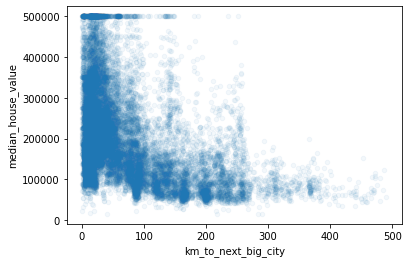

In [444]:
housing_raw.plot(kind = "scatter", x = 'km_to_next_big_city', y = 'median_house_value', alpha = 0.05)

This is promising!

* we see a negative slope
* we see the line at 500k on the very top of the scatter (representing the capping) that clearly hints at the amount of very highly priced houses decreasing with city proximity 
* we also see a kind of triangle with higher density on the left that shows very well how the density of highly priced houses decreases with higher distance from a bigger city 

In [445]:
#Let us take a look at how each attribute correlates with the target value
corr_matrix = pd.DataFrame(housing_raw.corr())
corr_matrix = corr_matrix.round(decimals = 2)
corr_matrix["median_house_value"].sort_values(ascending = False, key = abs)


median_house_value           1.00
median_income                0.69
km_to_next_big_city         -0.43
young_ppl_high_income_idx   -0.32
households_per_pop           0.26
rooms_per_person             0.21
latitude                    -0.14
total_rooms                  0.13
housing_median_age           0.11
households                   0.07
longitude                   -0.05
total_bedrooms               0.05
population                  -0.02
Name: median_house_value, dtype: float64

This is super promising: I managed to create new attributes that correlate higher with the target value than all the others:

* **km_to_next_big_city** -> shortest distance to a city of more than 700k inhabitants
* **young_ppl_high_income_idx** -> an index for a young population with high income, indicates "trendy areas" and may partly account for areas that cost more even though the living space is smaller per person.
* **households_per_pop** -> I managed to get a higher correlation value out of one of the least promising features - this may account for more trendy areas, too - this should be higher in cities (people probably are more likely to live alone here) and is another indicator for living space size.
* **bedrooms_per_rooms** -> self explanatory
* **rooms_per_person** -> how many rooms (~how much space a person has) may indicate life quality



Here we can see the correlations nicely visualized as a heatmap:

<AxesSubplot:>

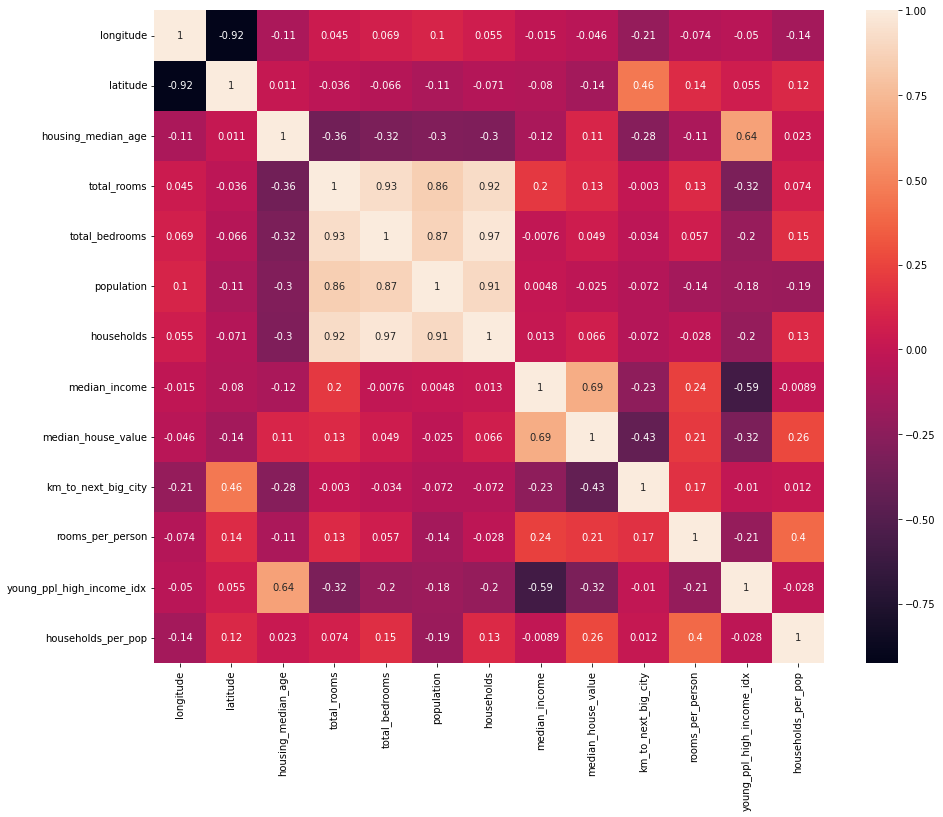

In [446]:
import seaborn as sns

plt.figure(figsize=(15,12))
sns.heatmap(housing_raw.corr(), annot=True)

And here we can look at the pairplot:

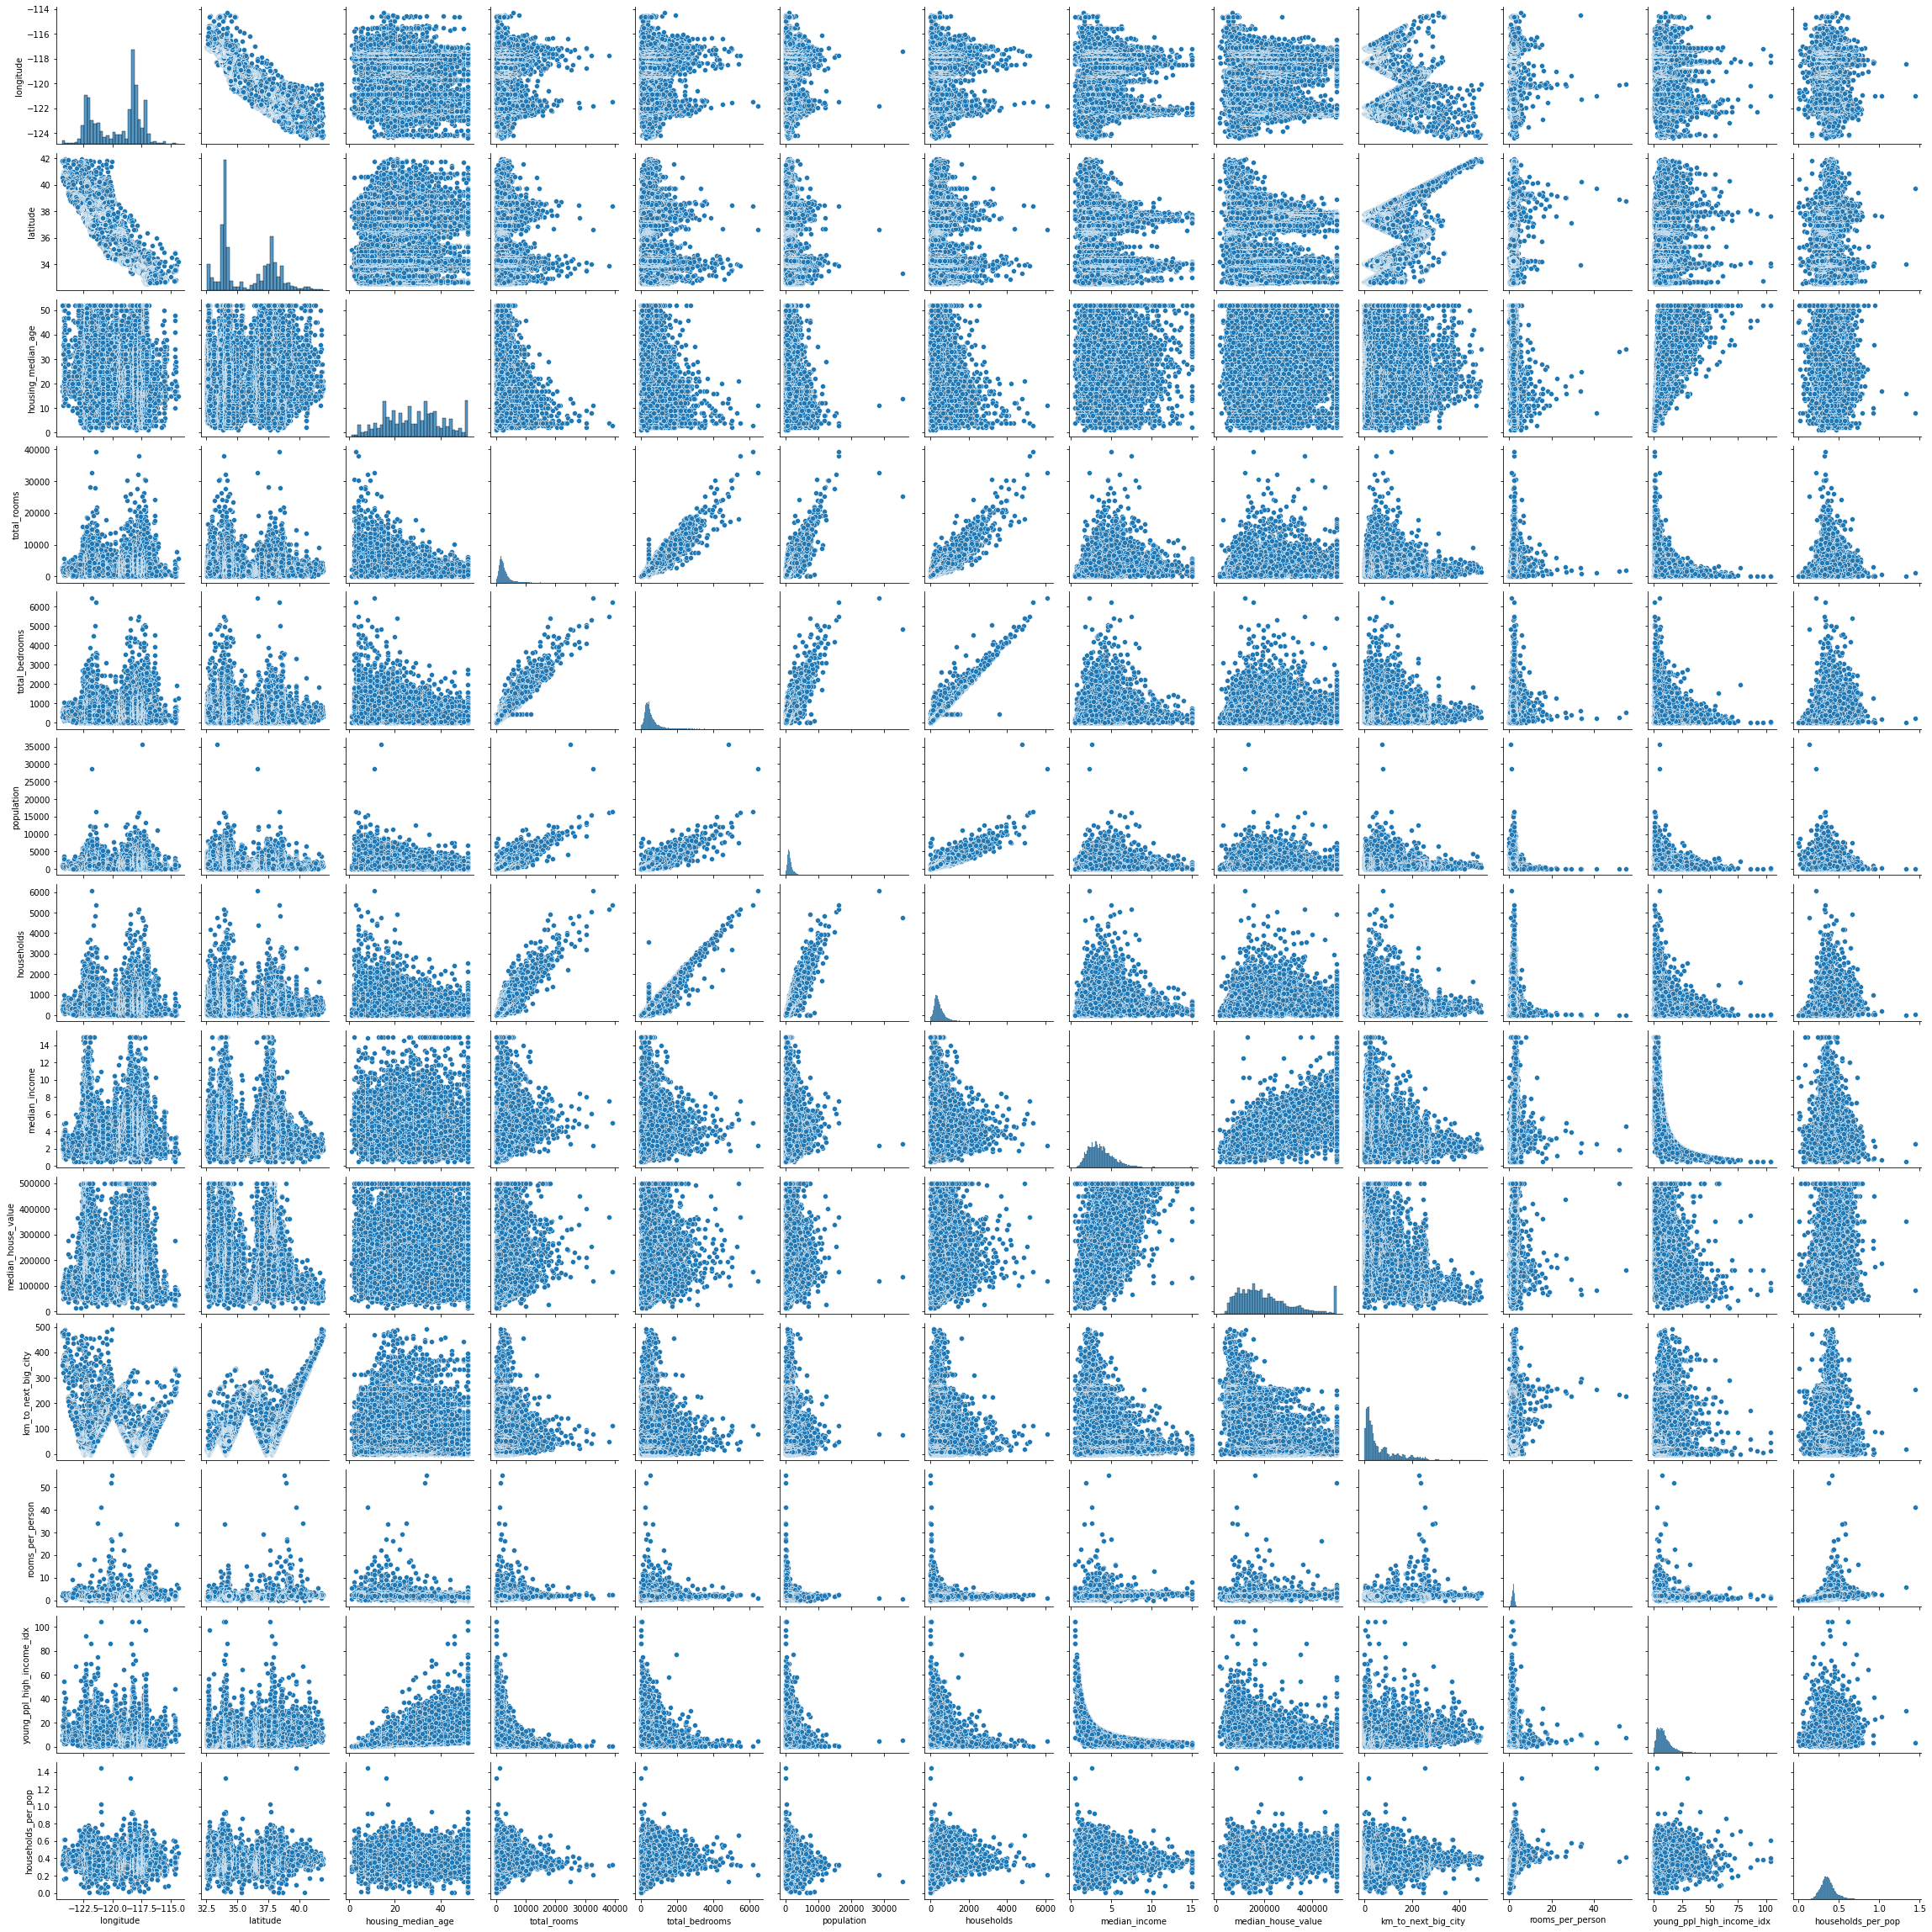

In [447]:
sns.pairplot(housing_raw)

<h4>Creating train/test split</h4>

In [448]:
#creating income categories as this is an important attribute for estimating housing prices (corr)

housing_raw["income_cat"] = pd.cut(
                               #1D input array to be binned
                               housing_raw["median_income"], 
                               #bins = sequence of scalars : defines bin edges allowing for non-uniform width
                               bins = [0, 1.5, 3, 4.5, 6, np.inf], 
                               #specifies the labels for the returned bins
                               labels = [1, 2, 3, 4, 5]
)



In [449]:
housing_raw.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  \
0       322.0       126.0         8.3252            452600.0        NEAR BAY   
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY   
2       496.0       177.0         7.2574            352100.0        NEAR BAY   
3       558.0       219.0         5.6431            341300.0        NEAR BAY   
4       565.0       259.0         3.8462            342200.0        NEAR BAY   

   km_to_next_big_city  rooms_per_person  young_ppl_high_income_idx  \
0            21.271727          2.732919                   4.924807   
1            20.901935          2.956685                   2.529694   
2            18.830721          2.957661                   7.165100   
3            18.049451          2.283154                   9.214793   
4            18.049451          2.879646                  13.519838   

   households_per_pop income_cat  
0            0.391304          5  
1            0.473969          5  
2            0.356855          5  
3            0.392473          4  
4            0.458407          3

In [450]:
from sklearn.model_selection import StratifiedShuffleSplit

#StratifiedShuffleSplit Provides train/test indices to split data in train/test sets
#n_splits is the number of splittig iterations
#test_size defines the percentage of our dataset that we want to keep for testing
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing_raw, housing_raw["income_cat"]):
    ctprx_strat_train_set = housing_raw.loc[train_index] #collects districts by index
    ctprx_strat_test_set = housing_raw.loc[test_index]


In [451]:
#note to self: will give error if run multiple times as the axis will have been removed and thus not found
for set_ in (ctprx_strat_train_set, ctprx_strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [452]:
#getting a copy of training set to work with from here
housing_cityprox = ctprx_strat_train_set.drop("median_house_value", axis = 1)
housing_cityprox_labels = ctprx_strat_train_set["median_house_value"].copy()

housing_cityprox.head()


longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
17606    -121.89     37.29                38.0       1568.0           351.0   
18632    -121.93     37.05                14.0        679.0           108.0   
14650    -117.20     32.77                31.0       1952.0           471.0   
3230     -119.61     36.31                25.0       1847.0           371.0   
3555     -118.59     34.23                17.0       6592.0          1525.0   

       population  households  median_income ocean_proximity  \
17606       710.0       339.0         2.7042       <1H OCEAN   
18632       306.0       113.0         6.4214       <1H OCEAN   
14650       936.0       462.0         2.8621      NEAR OCEAN   
3230       1460.0       353.0         1.8839          INLAND   
3555       4459.0      1463.0         3.0347       <1H OCEAN   

       km_to_next_big_city  rooms_per_person  young_ppl_high_income_idx  \
17606             5.069017          2.208451                  14.052215   
18632            31.942600          2.218954                   2.180210   
14650             7.053278          2.085470                  10.831208   
3230            233.256541          1.265068                  13.270343   
3555             37.541409          1.478358                   5.601872   

       households_per_pop  
17606            0.477465  
18632            0.369281  
14650            0.493590  
3230             0.241781  
3555             0.328100

<h4>Preparing and Cleaning Data</h4>

In [453]:
#first we create a copy of housing cityprox without the categorical values
housing_cityprox_num = housing_cityprox.drop('ocean_proximity', axis = 1)
housing_cityprox_num.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
17606    -121.89     37.29                38.0       1568.0           351.0   
18632    -121.93     37.05                14.0        679.0           108.0   
14650    -117.20     32.77                31.0       1952.0           471.0   
3230     -119.61     36.31                25.0       1847.0           371.0   
3555     -118.59     34.23                17.0       6592.0          1525.0   

       population  households  median_income  km_to_next_big_city  \
17606       710.0       339.0         2.7042             5.069017   
18632       306.0       113.0         6.4214            31.942600   
14650       936.0       462.0         2.8621             7.053278   
3230       1460.0       353.0         1.8839           233.256541   
3555       4459.0      1463.0         3.0347            37.541409   

       rooms_per_person  young_ppl_high_income_idx  households_per_pop  
17606          2.208451                  14.052215            0.477465  
18632          2.218954                   2.180210            0.369281  
14650          2.085470                  10.831208            0.493590  
3230           1.265068                  13.270343            0.241781  
3555           1.478358                   5.601872            0.328100

Now that we have the numerical attributes only, we can use a pipeline to fill in the missing values and afterwards we will take care of the categorical attribute "ocean_proximity".

In [454]:
#cityprox_num_pipeline is a pipeline object
cityprox_num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = "median")), #technically not needed anymore now
    ('std_scaler', StandardScaler())
])

#transform the numerical housing data 
housing_cityprox_num_tr = cityprox_num_pipeline.fit_transform(housing_cityprox_num)


In [455]:
display(pd.DataFrame(housing_cityprox_labels))

median_house_value
17606            286600.0
18632            340600.0
14650            196900.0
3230              46300.0
3555             254500.0
...                   ...
6563             240200.0
12053            113000.0
13908             97800.0
11159            225900.0
15775            500001.0

[16512 rows x 1 columns]

In [456]:
#handle the categorical data

#(already done: first we import the Column Tansformer class)
#then we get the list of numerical column names and categorical column names 
#(we have just one, ocean_proximity)

ctprx_num_attribs = list(housing_cityprox_num) #list of dataframe returns first row 
ctprx_cat_attribs = ["ocean_proximity"]


ctprx_full_pipeline = ColumnTransformer([
    ("num", cityprox_num_pipeline, ctprx_num_attribs),
    ("cat", OneHotEncoder(), ctprx_cat_attribs)
])


housing_cityprox_prepared = ctprx_full_pipeline.fit_transform(housing_cityprox)

display(pd.DataFrame(housing_cityprox_prepared).head())

0         1         2         3         4         5         6   \
0 -1.156043  0.771950  0.743331 -0.493234 -0.445490 -0.636211 -0.420698   
1 -1.176025  0.659695 -1.165317 -0.908967 -1.036986 -0.998331 -1.022227   
2  1.186849 -1.342183  0.186642 -0.313660 -0.153393 -0.433639 -0.093318   
3 -0.017068  0.313576 -0.290520 -0.362762 -0.396807  0.036041 -0.383436   
4  0.492474 -0.659299 -0.926736  1.856193  2.412192  2.724154  2.570975   

         7         8         9         10        11   12   13   14   15   16  
0 -0.614937 -0.846244  0.185754  0.633930  1.213057  1.0  0.0  0.0  0.0  0.0  
1  1.336459 -0.495119  0.194402 -1.017626  0.054293  1.0  0.0  0.0  0.0  0.0  
2 -0.532046 -0.820318  0.084499  0.185844  1.385773  0.0  0.0  0.0  0.0  1.0  
3 -1.045566  2.135212 -0.590968  0.525161 -1.311371  0.0  1.0  0.0  0.0  0.0  
4 -0.441437 -0.421966 -0.415358 -0.541627 -0.386795  1.0  0.0  0.0  0.0  0.0

Now that the data is all prepared, we will try using a RandomForestRegressor and see whether our results have been improved.

<h4>Model: Random Forest Regression</h4>



In [457]:
#from sklearn.ensemble import RandomForestRegressor

forest_reg_ctprx = RandomForestRegressor()
forest_reg_ctprx.fit(housing_cityprox_prepared, housing_cityprox_labels)

RandomForestRegressor()

In [458]:
housing_ctprx_predictions = forest_reg_ctprx.predict(housing_cityprox_prepared)

new_forest_mse = mean_squared_error(housing_cityprox_labels, housing_ctprx_predictions)
new_forest_rmse = np.sqrt(new_forest_mse)
new_forest_rmse

17977.55888819888

In [459]:
#from sklearn.model_selection import cross_val_score

new_forest_scores = cross_val_score(forest_reg_ctprx, housing_cityprox_prepared, housing_cityprox_labels,
                                scoring="neg_mean_squared_error", cv=10)
new_forest_rmse_scores = np.sqrt(-new_forest_scores)
display_scores(new_forest_rmse_scores)

Scores: [48065.05000308 45265.8776154  48276.27126072 50228.6744628
 46873.01970162 51419.33632917 46923.33233613 45479.58685309
 51251.90710226 47859.88918434]
Mean: 48164.29448486127
Standard Deviation: 2081.3749702260197


<h4>Fine-Tuning the Model</h4>

As with our oiginal dataset, we are using GridSearch for finding the best combinations of hyperparameter values for the new RandomForestRegressor.

In [460]:
#from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 20, 30, 35, 40], 'max_features': [2, 4, 6, 8, 10, 15]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg_ctprx = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(forest_reg_ctprx, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True) 

grid_search.fit(housing_cityprox_prepared, housing_cityprox_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8, 10, 15],
                          'n_estimators': [3, 10, 20, 30, 35, 40]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [461]:
grid_search.best_estimator_

RandomForestRegressor(max_features=10, n_estimators=40, random_state=42)

In [462]:
#evaluation scores are also available
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

61235.73648621179 {'max_features': 2, 'n_estimators': 3}
53007.3838693114 {'max_features': 2, 'n_estimators': 10}
50909.47975555907 {'max_features': 2, 'n_estimators': 20}
50376.28077430425 {'max_features': 2, 'n_estimators': 30}
50330.93809604932 {'max_features': 2, 'n_estimators': 35}
50093.71881729093 {'max_features': 2, 'n_estimators': 40}
58199.679760377505 {'max_features': 4, 'n_estimators': 3}
50550.93279201896 {'max_features': 4, 'n_estimators': 10}
49077.21913231562 {'max_features': 4, 'n_estimators': 20}
48440.85814625592 {'max_features': 4, 'n_estimators': 30}
48212.08450763438 {'max_features': 4, 'n_estimators': 35}
48065.98497161967 {'max_features': 4, 'n_estimators': 40}
57242.9743527434 {'max_features': 6, 'n_estimators': 3}
50279.39943796591 {'max_features': 6, 'n_estimators': 10}
48643.82254853801 {'max_features': 6, 'n_estimators': 20}
47992.56681588062 {'max_features': 6, 'n_estimators': 30}
47812.99558779766 {'max_features': 6, 'n_estimators': 35}
47779.26038713573 

RMSE is better than what we got earlier (48793).

<h4>Analyzing the Model and its Errors</h4>

In [463]:
#we can often gain interesting insights on the problem at hand by deeper inspection of the best models
#f.e.RandomForestRegressor can indicate the relative importance of each attribute for making accurate predictions:

feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([5.97763018e-02, 5.58805698e-02, 2.41382033e-02, 1.24347485e-02,
       1.26605549e-02, 1.09834677e-02, 1.23193754e-02, 3.33228007e-01,
       1.08069339e-01, 1.31048399e-01, 2.86379322e-02, 6.76014025e-02,
       3.35272457e-03, 1.35755865e-01, 7.94293683e-05, 1.11857560e-03,
       2.91510379e-03])


We will now find out final rmse by evaluating on the test set.

In [464]:
final_model = grid_search.best_estimator_


X_test = ctprx_strat_test_set.drop("median_house_value", axis = 1)
y_test = ctprx_strat_test_set["median_house_value"].copy()

X_test_prepared = ctprx_full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [465]:
final_rmse

45733.44699077685

<h4>Computing a 95% Confidence Interval</h4>

In [466]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors)-1,
                        loc = squared_errors.mean(),
                        scale = stats.sem(squared_errors)))

array([43809.61020584, 47579.5586458 ])

If I get more data outside of my training set, in at least 95% of the cases I should have an rmse inside that interval. If it is lower then the model is not good enough.

In [467]:
housing_raw.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  \
0       322.0       126.0         8.3252            452600.0        NEAR BAY   
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY   
2       496.0       177.0         7.2574            352100.0        NEAR BAY   
3       558.0       219.0         5.6431            341300.0        NEAR BAY   
4       565.0       259.0         3.8462            342200.0        NEAR BAY   

   km_to_next_big_city  rooms_per_person  young_ppl_high_income_idx  \
0            21.271727          2.732919                   4.924807   
1            20.901935          2.956685                   2.529694   
2            18.830721          2.957661                   7.165100   
3            18.049451          2.283154                   9.214793   
4            18.049451          2.879646                  13.519838   

   households_per_pop income_cat  
0            0.391304          5  
1            0.473969          5  
2            0.356855          5  
3            0.392473          4  
4            0.458407          3

In [468]:
housing_cityprox.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
17606    -121.89     37.29                38.0       1568.0           351.0   
18632    -121.93     37.05                14.0        679.0           108.0   
14650    -117.20     32.77                31.0       1952.0           471.0   
3230     -119.61     36.31                25.0       1847.0           371.0   
3555     -118.59     34.23                17.0       6592.0          1525.0   

       population  households  median_income ocean_proximity  \
17606       710.0       339.0         2.7042       <1H OCEAN   
18632       306.0       113.0         6.4214       <1H OCEAN   
14650       936.0       462.0         2.8621      NEAR OCEAN   
3230       1460.0       353.0         1.8839          INLAND   
3555       4459.0      1463.0         3.0347       <1H OCEAN   

       km_to_next_big_city  rooms_per_person  young_ppl_high_income_idx  \
17606             5.069017          2.208451                  14.052215   
18632            31.942600          2.218954                   2.180210   
14650             7.053278          2.085470                  10.831208   
3230            233.256541          1.265068                  13.270343   
3555             37.541409          1.478358                   5.601872   

       households_per_pop  
17606            0.477465  
18632            0.369281  
14650            0.493590  
3230             0.241781  
3555             0.328100

<h4>Model Persistence Using Joblib</h4>

In [469]:
full_pipeline_plus_prediction = Pipeline([
        ("preparation", ctprx_full_pipeline),
        #using the random forest regressor with the params we found using gridsearch
        #grid_search.best_estimator_ == RandomForestRegressor(max_features = 8, n_estimators = 30, ...
        #...random_state = 42)
        ("rand_forest_reg", grid_search.best_estimator_) 
    ])

full_pipeline_plus_prediction.fit(housing_cityprox, housing_cityprox_labels)
#full_pipeline_with_predictor.predict(some_data)



Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income',
                                                   'km_to_next_big_city',
                                                   'rooms

In [470]:
housing_model_ctprx = full_pipeline_plus_prediction

In [471]:
import joblib

joblib.dump(housing_model_ctprx, "housing_model_ctprx.pkl")



['housing_model_ctprx.pkl']

In [472]:
model_loaded = joblib.load("housing_model_ctprx.pkl")

#model_loaded

<h3>Final Reflections</h3>

* I successfully used feature engineering to get more information out of the dataset
* I modeled new attributes with correlations higher than the ones given
* With a final rmse of arounf 45,5k my rmse is ~6% lower than the one of the original model with an rmse of 47730
* It needs to be emphasized here that I worked on the model from the book for educational reasons to get more in depth here, the results can still be improved by using another model. The lowest rmse that I found for this particular dataset online was 41k